# Projet Knapsack Problem 0-1

**Équipe:** Chaabane, Arman, Bartosz, Ahmed

## Structure du projet

1. Infrastructure commune (Classes et structures de données)
2. Algorithmes implémentés
3. Système de benchmarking complet
4. Analyse comparative approfondie

---
## 1. Configuration et Imports

In [ ]:
import time
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from typing import Literal, Optional, Tuple, List
from dataclasses import dataclass
from itertools import combinations
from pathlib import Path
from collections import defaultdict
from types import SimpleNamespace

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

ALGO_COLORS = {
    'Brute Force': '#e41a1c',
    'Dynamic Programming': '#377eb8',
    'DP Top-Down': '#4daf4a',
    'Branch and Bound': '#984ea3',
    'Greedy Ratio': '#ff7f00', 
    'Greedy Value': '#ffff33', 
    'Greedy Weight': '#a65628', 
    'Fractional Knapsack': '#f781bf',
    'Randomized': '#999999', 
    'Genetic Algorithm': '#17becf',  
    'Genetic Adaptive': '#1f77b4',      
    'Simulated Annealing': '#d62728',   
    'SA Adaptive': '#ff9896',          
    'FTPAS (ε=0.1)': '#9467bd',         
    'FTPAS (ε=0.05)': '#8c564b',        
    'FTPAS Adaptive': '#e377c2',        
}

## Générateur de Benchmarks Knapsack

Ce générateur permet de créer des fichiers de benchmark personnalisés avec différents paramètres :
- **Type de corrélation** : uncorrelated, weakly_correlated, strongly_correlated, similar_weights
- **Nombre d'items (n)** : nombre d'objets dans l'instance
- **Plage des poids (R)** : valeur maximale pour les poids générés aléatoirement
- **Capacité** : peut être spécifiée ou calculée automatiquement (généralement 50% de la somme des poids)

In [ ]:
GENERATED_DIR = "benchmarks/generated"

@dataclass
class KnapsackInstance:
    n: int
    capacity: int
    weights: List[int]
    values: List[int]
    correlation_type: str
    
    def __str__(self):
        return f"KnapsackInstance(n={self.n}, capacity={self.capacity}, type={self.correlation_type})"


class KnapsackBenchmarkGenerator:
    CORRELATION_TYPES = [
        'uncorrelated',
        'weakly_correlated', 
        'strongly_correlated',
        'similar_weights',
        'inverse_strongly_correlated'
    ]
    
    def __init__(self):
        self.rng = np.random.default_rng()
    
    def generate(self, n: int, R: int = 1000, capacity: Optional[int] = None,
                 capacity_ratio: float = 0.5, correlation_type: str = 'uncorrelated',
                 correlation_param: float = 100.0) -> KnapsackInstance:
        if correlation_type not in self.CORRELATION_TYPES:
            raise ValueError(f"Type inconnu: {correlation_type}. Choix: {self.CORRELATION_TYPES}")
        
        weights = self._generate_weights(n, R, correlation_type, correlation_param)
        values = self._generate_values(weights, R, correlation_type, correlation_param)
        
        if capacity is None:
            capacity = int(capacity_ratio * sum(weights))
        capacity = max(1, capacity)
        
        return KnapsackInstance(n=n, capacity=capacity, weights=weights.tolist(), 
                                values=values.tolist(), correlation_type=correlation_type)
    
    def _generate_weights(self, n: int, R: int, correlation_type: str, correlation_param: float) -> np.ndarray:
        if correlation_type == 'similar_weights':
            weights = self.rng.normal(R / 2, correlation_param, n)
            weights = np.clip(weights, 1, R).astype(int)
        else:
            weights = self.rng.integers(1, R + 1, n)
        return weights.astype(int)
    
    def _generate_values(self, weights: np.ndarray, R: int, correlation_type: str, correlation_param: float) -> np.ndarray:
        n = len(weights)
        if correlation_type == 'uncorrelated':
            values = self.rng.integers(1, R + 1, n)
        elif correlation_type == 'weakly_correlated':
            noise = self.rng.integers(-int(correlation_param), int(correlation_param) + 1, n)
            values = np.maximum(weights + noise, 1)
        elif correlation_type == 'strongly_correlated':
            values = weights + int(correlation_param)
        elif correlation_type == 'similar_weights':
            values = self.rng.integers(1, R + 1, n)
        elif correlation_type == 'inverse_strongly_correlated':
            values = np.maximum(weights.max() - weights + int(correlation_param), 1)
        return values.astype(int)
    
    def _build_filename(self, instance: KnapsackInstance, index: int = None, format: str = 'standard') -> str:
        ext = '.kp' if format == 'kp' else '.txt'
        base = f"{instance.correlation_type}_n{instance.n}_c{instance.capacity}"
        if index is not None:
            return f"{base}_{index:03d}{ext}"
        return f"{base}{ext}"
    
    def save_to_file(self, instance: KnapsackInstance, filepath: str = None,
                     index: int = None, format: Literal['standard', 'kp'] = 'standard') -> str:
        if filepath is None:
            filepath = os.path.join(GENERATED_DIR, self._build_filename(instance, index, format))
        
        os.makedirs(os.path.dirname(filepath) if os.path.dirname(filepath) else '.', exist_ok=True)
        with open(filepath, 'w') as f:
            if format == 'standard':
                f.write(f"{instance.n} {instance.capacity}\n")
                for v, w in zip(instance.values, instance.weights):
                    f.write(f"{v} {w}\n")
            elif format == 'kp':
                f.write(f"\n{instance.n}\n{instance.capacity}\n\n")
                for v, w in zip(instance.values, instance.weights):
                    f.write(f"{v} {w}\n")
        return filepath


def generate_benchmarks(n: int, capacity: int = None, correlation = 'uncorrelated',
                        R: int = 1000, count: int = 1, format: str = 'standard') -> List[KnapsackInstance]:
    """
    Génère un ou plusieurs fichiers de benchmark.
    
    Args:
        n: Nombre d'items
        capacity: Capacité du sac (None = 50% de la somme des poids)
        correlation: Type ou liste de types ('uncorrelated', 'weakly_correlated', 
                     'strongly_correlated', 'similar_weights', 'inverse_strongly_correlated')
        R: Poids max [1, R]
        count: Nombre de fichiers à générer par type
        format: 'standard' (.txt) ou 'kp'
    """
    generator = KnapsackBenchmarkGenerator()
    instances = []
    
    correlations = [correlation] if isinstance(correlation, str) else correlation
    
    for corr_type in correlations:
        for i in range(count):
            instance = generator.generate(n=n, R=R, capacity=capacity, correlation_type=corr_type)
            index = i + 1 if count > 1 else None
            filepath = generator.save_to_file(instance, index=index, format=format)
            instances.append(instance)
            print(f"✓ {filepath}")
    
    total = len(correlations) * count
    print(f"\n{total} fichier(s) généré(s) dans {GENERATED_DIR}/")
    return instances


print(f"Dossier: {GENERATED_DIR}")
print(f"Types: {KnapsackBenchmarkGenerator.CORRELATION_TYPES}")

Dossier: benchmarks/generated
Types: ['uncorrelated', 'weakly_correlated', 'strongly_correlated', 'similar_weights', 'inverse_strongly_correlated']


### Exemples d'utilisation du générateur

In [ ]:
# =============================================================================
# GÉNÉRATION DE BENCHMARKS
# =============================================================================
# Types: 'uncorrelated', 'weakly_correlated', 'strongly_correlated', 
#        'similar_weights', 'inverse_strongly_correlated'
# =============================================================================
generate_benchmarks(n=100, capacity=1000, correlation=['uncorrelated', 'strongly_correlated', 'weakly_correlated'], count=3)
generate_benchmarks(n=500, capacity=1000, correlation=['uncorrelated', 'strongly_correlated', 'weakly_correlated'], count=3)
generate_benchmarks(n=1000, capacity=1000, correlation=['uncorrelated', 'strongly_correlated', 'weakly_correlated'], count=3)
generate_benchmarks(n=2000, capacity=1000, correlation=['uncorrelated', 'strongly_correlated', 'weakly_correlated'], count=3)
generate_benchmarks(n=5000, capacity=1000, correlation=['uncorrelated', 'strongly_correlated', 'weakly_correlated'], count=2)
generate_benchmarks(n=10000, capacity=1000, correlation=['uncorrelated', 'strongly_correlated', 'weakly_correlated'])
generate_benchmarks(n=100, capacity=1000, correlation='similar_weights', count=3)
generate_benchmarks(n=200, capacity=1000, correlation='similar_weights', count=2)
generate_benchmarks(n=1000, capacity=1000, correlation='similar_weights', count=2)
generate_benchmarks(n=500, capacity=1000, correlation='similar_weights', count=2)







# generate_benchmarks(n=100, capacity=5000, correlation='uncorrelated')
# generate_benchmarks(n=100, capacity=5000, correlation='strongly_correlated', count=5)
# generate_benchmarks(n=100, capacity=5000, correlation=['uncorrelated', 'strongly_correlated', 'weakly_correlated'])
# generate_benchmarks(n=100, capacity=5000, correlation=['uncorrelated', 'strongly_correlated', 'weakly_correlated'], count=5)

✓ benchmarks/generated\uncorrelated_n100_c2000_001.txt
✓ benchmarks/generated\uncorrelated_n100_c2000_002.txt
✓ benchmarks/generated\uncorrelated_n100_c2000_003.txt
✓ benchmarks/generated\strongly_correlated_n100_c2000_001.txt
✓ benchmarks/generated\strongly_correlated_n100_c2000_002.txt
✓ benchmarks/generated\strongly_correlated_n100_c2000_003.txt
✓ benchmarks/generated\weakly_correlated_n100_c2000_001.txt
✓ benchmarks/generated\weakly_correlated_n100_c2000_002.txt
✓ benchmarks/generated\weakly_correlated_n100_c2000_003.txt

9 fichier(s) généré(s) dans benchmarks/generated/
✓ benchmarks/generated\uncorrelated_n500_c2000_001.txt
✓ benchmarks/generated\uncorrelated_n500_c2000_002.txt
✓ benchmarks/generated\uncorrelated_n500_c2000_003.txt
✓ benchmarks/generated\strongly_correlated_n500_c2000_001.txt
✓ benchmarks/generated\strongly_correlated_n500_c2000_002.txt
✓ benchmarks/generated\strongly_correlated_n500_c2000_003.txt
✓ benchmarks/generated\weakly_correlated_n500_c2000_001.txt
✓ bench

[KnapsackInstance(n=500, capacity=2000, weights=[392, 534, 380, 413, 470, 688, 405, 593, 513, 600, 499, 426, 492, 298, 606, 255, 546, 528, 427, 473, 514, 396, 462, 531, 543, 592, 446, 660, 614, 504, 457, 437, 403, 507, 452, 578, 469, 561, 551, 497, 335, 498, 618, 520, 310, 510, 602, 492, 412, 688, 391, 558, 442, 601, 458, 488, 620, 355, 415, 662, 627, 558, 567, 690, 553, 418, 489, 422, 488, 683, 465, 300, 441, 380, 376, 547, 650, 487, 470, 562, 421, 391, 637, 503, 553, 387, 340, 356, 458, 438, 418, 408, 272, 416, 537, 483, 578, 488, 627, 501, 701, 404, 409, 305, 472, 579, 664, 492, 591, 433, 633, 603, 712, 496, 523, 444, 507, 654, 751, 468, 251, 284, 542, 466, 610, 714, 601, 692, 535, 585, 309, 677, 385, 426, 453, 506, 422, 550, 462, 695, 487, 377, 465, 500, 576, 541, 636, 469, 517, 561, 654, 356, 466, 431, 554, 523, 544, 522, 611, 509, 342, 654, 505, 492, 480, 549, 632, 488, 484, 563, 532, 586, 545, 531, 637, 418, 563, 537, 469, 374, 541, 582, 516, 547, 413, 548, 570, 533, 600, 618, 4

---
## 2. Structures de Données Communes

In [5]:
class Item:
    """Représente un item avec son poids et sa valeur"""
    def __init__(self, item_id, weight, value):
        self.id = item_id
        self.weight = weight
        self.value = value
    
    def ratio(self):
        return self.value / self.weight if self.weight > 0 else 0
    
    def __repr__(self):
        return f"Item({self.id}, w={self.weight}, v={self.value})"


class Problem:
    """Représente une instance du problème de knapsack"""
    def __init__(self, items, capacity):
        self.items = items
        self.capacity = capacity
        self.n = len(items)


class Solution:
    """Représente une solution au problème"""
    def __init__(self, selected_items, total_value, total_weight, time_taken):
        self.selected_items = selected_items
        self.total_value = total_value
        self.total_weight = total_weight
        self.time = time_taken
        self.usage_percent = (total_weight / 1.0) * 100  # Sera mis à jour

---
## 3. Parsing et Gestion des Benchmarks

In [6]:
# Note: La fonction parse_benchmark_file() est maintenant définie dans la section 5.1
# avec discover_benchmarks() pour supporter les deux formats de fichiers (.txt et .kp)
# Voir la cellule "Découverte automatique des benchmarks" plus bas
pass

---
## 4. Algorithmes Implémentés

### 4.1 Brute Force

In [7]:
def brute_force(problem):
    """Algorithme exhaustif O(2^n)"""
    start_time = time.time()
    
    best_value = 0
    best_weight = 0
    best_items = []
    
    for size in range(problem.n + 1):
        for combo in combinations(range(problem.n), size):
            total_weight = sum(problem.items[i].weight for i in combo)
            total_value = sum(problem.items[i].value for i in combo)
            
            if total_weight <= problem.capacity and total_value > best_value:
                best_value = total_value
                best_weight = total_weight
                best_items = list(combo)
    
    time_taken = time.time() - start_time
    sol = Solution(best_items, best_value, best_weight, time_taken)
    sol.usage_percent = (best_weight / problem.capacity) * 100 if problem.capacity > 0 else 0
    return sol

### 4.2 Programmation Dynamique

In [8]:
def dynamic_programming(problem):
    """Programmation dynamique O(n x C) avec protection"""
    start_time = time.time()
    
    n = problem.n
    C = problem.capacity
    
    total_cells = n * C
    if total_cells > 10_000_000:
        print(f"DP Skip: matrice trop grande ({n}×{C:,} = {total_cells:,})")
        return None
    
    estimated_mb = (total_cells * 8) / (1024 * 1024)
    if estimated_mb > 500:
        print(f"DP Skip: mémoire > 500 MB ({estimated_mb:.0f} MB)")
        return None
    
    dp = [[0 for _ in range(C + 1)] for _ in range(n + 1)]
    
    for i in range(1, n + 1):
        item = problem.items[i - 1]
        for w in range(C + 1):
            dp[i][w] = dp[i - 1][w]
            if item.weight <= w:
                dp[i][w] = max(dp[i][w], dp[i - 1][w - item.weight] + item.value)
    
    # Reconstruction
    selected = []
    w = C
    for i in range(n, 0, -1):
        if dp[i][w] != dp[i - 1][w]:
            selected.append(i - 1)
            w -= problem.items[i - 1].weight
    
    total_value = dp[n][C]
    total_weight = sum(problem.items[i].weight for i in selected)
    
    time_taken = time.time() - start_time
    sol = Solution(selected, total_value, total_weight, time_taken)
    sol.usage_percent = (total_weight / problem.capacity) * 100 if problem.capacity > 0 else 0
    return sol

### 4.2.1 Programmation Dynamique Top-Down

In [9]:
def dynamic_programming_topdown(problem):
    """
    Programmation dynamique Top-Down avec mémoïsation
    
    Complexité temporelle: O(n × C)
    Complexité spatiale: O(n × C) pour le cache + O(n) pour la pile de récursion
    
    Avantages par rapport à Bottom-Up:
    - Ne calcule que les sous-problèmes nécessaires
    - Plus intuitif (suit la définition récursive)
    - Peut être plus rapide si tous les sous-problèmes ne sont pas nécessaires
    
    Returns:
        Solution object
    """
    import sys
    start_time = time.time()
    
    n = problem.n
    C = problem.capacity
    items = problem.items
    
    # Protection contre les grandes instances
    total_cells = n * C
    if total_cells > 10_000_000:
        print(f"DP Top-Down Skip: cache trop grand ({n}×{C:,} = {total_cells:,})")
        return None
    
    # Augmenter la limite de récursion si nécessaire
    old_limit = sys.getrecursionlimit()
    if n + 100 > old_limit:
        sys.setrecursionlimit(max(n + 100, old_limit))
    
    # Cache pour mémoïsation: memo[i][w] = valeur max avec items 0..i-1 et capacité w
    memo = {}
    
    def knapsack(i, w):
        """
        Retourne la valeur maximale possible avec les items 0..i-1 et capacité w
        """
        # Cas de base
        if i == 0 or w == 0:
            return 0
        
        # Vérifier le cache
        if (i, w) in memo:
            return memo[(i, w)]
        
        item = items[i - 1]
        
        # Si l'item est trop lourd, on ne peut pas le prendre
        if item.weight > w:
            result = knapsack(i - 1, w)
        else:
            # Max entre prendre et ne pas prendre l'item
            not_take = knapsack(i - 1, w)
            take = knapsack(i - 1, w - item.weight) + item.value
            result = max(not_take, take)
        
        memo[(i, w)] = result
        return result
    
    # Calculer la valeur optimale
    try:
        best_value = knapsack(n, C)
    except RecursionError:
        print(f"DP Top-Down Skip: récursion trop profonde (n={n})")
        sys.setrecursionlimit(old_limit)
        return None
    
    # Reconstruction de la solution
    selected = []
    w = C
    for i in range(n, 0, -1):
        if w == 0:
            break
        item = items[i - 1]
        # Si la valeur change quand on exclut cet item, c'est qu'on l'a pris
        val_with = memo.get((i, w), 0)
        val_without = memo.get((i - 1, w), 0)
        if val_with != val_without:
            selected.append(i - 1)
            w -= item.weight
    
    total_weight = sum(items[i].weight for i in selected)
    
    # Restaurer la limite de récursion
    sys.setrecursionlimit(old_limit)
    
    time_taken = time.time() - start_time
    sol = Solution(selected, best_value, total_weight, time_taken)
    sol.usage_percent = (total_weight / problem.capacity) * 100 if problem.capacity > 0 else 0
    return sol

### 4.3 Branch and Bound

In [10]:
def branch_and_bound(problem):
    """Branch and Bound avec élagage"""
    start_time = time.time()
    
    sorted_indices = sorted(range(problem.n), 
                          key=lambda i: problem.items[i].ratio(), 
                          reverse=True)
    
    best_value = 0
    best_solution = []
    
    def bound(level, current_weight, current_value):
        if current_weight >= problem.capacity:
            return 0
        
        value_bound = current_value
        total_weight = current_weight
        
        for i in range(level, problem.n):
            idx = sorted_indices[i]
            item = problem.items[idx]
            
            if total_weight + item.weight <= problem.capacity:
                total_weight += item.weight
                value_bound += item.value
            else:
                remaining = problem.capacity - total_weight
                value_bound += item.value * (remaining / item.weight)
                break
        
        return value_bound
    
    def branch(level, current_weight, current_value, current_items):
        nonlocal best_value, best_solution
        
        if level == problem.n:
            if current_value > best_value:
                best_value = current_value
                best_solution = current_items[:]
            return
        
        idx = sorted_indices[level]
        item = problem.items[idx]
        
        if current_weight + item.weight <= problem.capacity:
            new_value = current_value + item.value
            if bound(level + 1, current_weight + item.weight, new_value) > best_value:
                current_items.append(idx)
                branch(level + 1, current_weight + item.weight, new_value, current_items)
                current_items.pop()
        
        if bound(level + 1, current_weight, current_value) > best_value:
            branch(level + 1, current_weight, current_value, current_items)
    
    branch(0, 0, 0, [])
    
    total_weight = sum(problem.items[i].weight for i in best_solution)
    time_taken = time.time() - start_time
    
    sol = Solution(best_solution, best_value, total_weight, time_taken)
    sol.usage_percent = (total_weight / problem.capacity) * 100 if problem.capacity > 0 else 0
    return sol

### 4.4 Algorithmes Gloutons

In [11]:
def greedy_by_value(problem):
    """Greedy par valeur décroissante"""
    start_time = time.time()
    
    sorted_items = sorted(enumerate(problem.items), key=lambda x: x[1].value, reverse=True)
    
    selected = []
    total_weight = 0
    total_value = 0
    
    for idx, item in sorted_items:
        if total_weight + item.weight <= problem.capacity:
            selected.append(idx)
            total_weight += item.weight
            total_value += item.value
    
    time_taken = time.time() - start_time
    sol = Solution(selected, total_value, total_weight, time_taken)
    sol.usage_percent = (total_weight / problem.capacity) * 100 if problem.capacity > 0 else 0
    return sol


def greedy_by_weight(problem):
    """Greedy par poids croissant"""
    start_time = time.time()
    
    sorted_items = sorted(enumerate(problem.items), key=lambda x: x[1].weight)
    
    selected = []
    total_weight = 0
    total_value = 0
    
    for idx, item in sorted_items:
        if total_weight + item.weight <= problem.capacity:
            selected.append(idx)
            total_weight += item.weight
            total_value += item.value
    
    time_taken = time.time() - start_time
    sol = Solution(selected, total_value, total_weight, time_taken)
    sol.usage_percent = (total_weight / problem.capacity) * 100 if problem.capacity > 0 else 0
    return sol


def greedy_by_ratio(problem):
    """Greedy par ratio valeur/poids décroissant"""
    start_time = time.time()
    
    sorted_items = sorted(enumerate(problem.items), key=lambda x: x[1].ratio(), reverse=True)
    
    selected = []
    total_weight = 0
    total_value = 0
    
    for idx, item in sorted_items:
        if total_weight + item.weight <= problem.capacity:
            selected.append(idx)
            total_weight += item.weight
            total_value += item.value
    
    time_taken = time.time() - start_time
    sol = Solution(selected, total_value, total_weight, time_taken)
    sol.usage_percent = (total_weight / problem.capacity) * 100 if problem.capacity > 0 else 0
    return sol

### 4.4.1 Fractional Knapsack (Sac à dos fractionnel)

In [12]:
def fractional_knapsack(problem):
    """
    Fractional Knapsack - Algorithme glouton optimal pour le sac à dos fractionnel
    
    Complexité temporelle: O(n log n) pour le tri
    Complexité spatiale: O(n)
    
    Différence avec 0-1 Knapsack:
    - Permet de prendre une FRACTION d'un item
    - Solution optimale garantie (contrairement au 0-1)
    - Sert de borne supérieure pour le 0-1 Knapsack
    
    Stratégie: Trier par ratio valeur/poids décroissant et prendre 
    les items dans cet ordre (fractions si nécessaire)
    
    Returns:
        Solution object avec fraction_taken indiquant les fractions prises
    """
    start_time = time.time()
    
    n = problem.n
    capacity = problem.capacity
    items = problem.items
    
    # Trier les items par ratio valeur/poids décroissant
    sorted_items = sorted(enumerate(items), key=lambda x: x[1].ratio(), reverse=True)
    
    total_value = 0.0
    total_weight = 0.0
    selected = []  # Liste de tuples (index, fraction_prise)
    fractions = {}  # Pour stocker les fractions de chaque item
    
    remaining_capacity = capacity
    
    for idx, item in sorted_items:
        if remaining_capacity <= 0:
            break
            
        if item.weight <= remaining_capacity:
            # Prendre l'item entier
            selected.append(idx)
            fractions[idx] = 1.0
            total_value += item.value
            total_weight += item.weight
            remaining_capacity -= item.weight
        else:
            # Prendre une fraction de l'item
            fraction = remaining_capacity / item.weight
            fractions[idx] = fraction
            total_value += item.value * fraction
            total_weight += item.weight * fraction
            selected.append(idx)
            remaining_capacity = 0
    
    time_taken = time.time() - start_time
    
    # Créer la solution
    # Note: total_value peut être un float, on le garde ainsi pour la précision
    sol = Solution(selected, total_value, total_weight, time_taken)
    sol.usage_percent = (total_weight / capacity) * 100 if capacity > 0 else 0
    sol.fractions = fractions  # Stocker les fractions pour référence
    sol.is_fractional = True  # Marquer comme solution fractionnelle
    
    return sol


def fractional_knapsack_bound(problem):
    """
    Calcule uniquement la borne supérieure (valeur max du fractional knapsack)
    Utile pour Branch and Bound et comparaisons
    
    Returns:
        float: Valeur maximale possible (borne supérieure pour 0-1)
    """
    sorted_items = sorted(problem.items, key=lambda x: x.ratio(), reverse=True)
    
    total_value = 0.0
    remaining_capacity = problem.capacity
    
    for item in sorted_items:
        if remaining_capacity <= 0:
            break
        if item.weight <= remaining_capacity:
            total_value += item.value
            remaining_capacity -= item.weight
        else:
            total_value += item.value * (remaining_capacity / item.weight)
            break
    
    return total_value

### 4.5 Approche Randomisée

In [13]:
def randomized_approach(problem, iterations=1000, seed=None):
    """Approche randomisée multi-start"""
    start_time = time.time()
    
    if seed is not None:
        random.seed(seed)
    
    best_value = 0
    best_weight = 0
    best_items = []
    
    for _ in range(iterations):
        indices = list(range(problem.n))
        random.shuffle(indices)
        
        selected = []
        total_weight = 0
        total_value = 0
        
        for idx in indices:
            item = problem.items[idx]
            if total_weight + item.weight <= problem.capacity:
                selected.append(idx)
                total_weight += item.weight
                total_value += item.value
        
        if total_value > best_value:
            best_value = total_value
            best_weight = total_weight
            best_items = selected
    
    time_taken = time.time() - start_time
    sol = Solution(best_items, best_value, best_weight, time_taken)
    sol.usage_percent = (best_weight / problem.capacity) * 100 if problem.capacity > 0 else 0
    return sol

### 4.6 Algorithme Génétique (Genetic Algorithm)

In [14]:
def genetic_algorithm(problem, population_size=100, generations=50, 
                     crossover_rate=0.8, mutation_rate=0.02, 
                     elitism_count=5, seed=None):
    """

    Args:
        problem: Instance du problème (Problem object)
        population_size: Taille de la population (nombre de chromosomes)
        generations: Nombre de générations (itérations)
        crossover_rate: Probabilité de croisement (0.0 à 1.0)
        mutation_rate: Probabilité de mutation par gène (0.0 à 1.0)
        elitism_count: Nombre de meilleures solutions à conserver
        seed: Graine aléatoire pour reproductibilité
    
    Returns:
        Solution object
    """
    start_time = time.time()
    
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
    
    n = problem.n
    capacity = problem.capacity
    items = problem.items
    
    # === 1. FONCTION DE FITNESS ===
    def fitness(chromosome):
        """Qualité d'un chromosome (solution)"""
        total_weight = sum(chromosome[i] * items[i].weight for i in range(n))
        total_value = sum(chromosome[i] * items[i].value for i in range(n))
        
        # Pénalité si capacité dépassée
        if total_weight > capacity:
            # Pénalité proportionnelle au dépassement
            penalty = (total_weight - capacity) * 10
            return max(0, total_value - penalty)
        return total_value
    
    # POPULATION INITIALE
    def create_initial_population():
        """Crée la population initiale avec différentes stratégies"""
        population = []
        
        # 50% solutions aléatoires
        for _ in range(population_size // 2):
            chromosome = [random.randint(0, 1) for _ in range(n)]
            population.append(chromosome)
        
        # 25% solutions greedy (ratio)
        sorted_indices = sorted(range(n), key=lambda i: items[i].ratio(), reverse=True)
        for _ in range(population_size // 4):
            chromosome = [0] * n
            weight = 0
            for idx in sorted_indices:
                if weight + items[idx].weight <= capacity and random.random() > 0.3:
                    chromosome[idx] = 1
                    weight += items[idx].weight
            population.append(chromosome)
        
        # 25% solutions avec densité variable
        for _ in range(population_size - len(population)):
            chromosome = [0] * n
            density = random.uniform(0.2, 0.8)
            weight = 0
            for i in range(n):
                if random.random() < density and weight + items[i].weight <= capacity:
                    chromosome[i] = 1
                    weight += items[i].weight
            population.append(chromosome)
        
        return population
    
    # SÉLECTION PAR TOURNOI
    def tournament_selection(population, fitnesses, tournament_size=3):
        """Sélectionne un individu par tournoi"""
        tournament_indices = random.sample(range(len(population)), tournament_size)
        tournament_fitnesses = [fitnesses[i] for i in tournament_indices]
        winner_idx = tournament_indices[tournament_fitnesses.index(max(tournament_fitnesses))]
        return population[winner_idx]
    
    # CROISEMENT (CROSSOVER)
    def crossover(parent1, parent2):
        """Croisement à deux points"""
        if random.random() > crossover_rate:
            return parent1[:], parent2[:]
        
        # Deux points de coupure
        point1 = random.randint(1, n - 2)
        point2 = random.randint(point1 + 1, n - 1)
        
        child1 = parent1[:point1] + parent2[point1:point2] + parent1[point2:]
        child2 = parent2[:point1] + parent1[point1:point2] + parent2[point2:]
        
        return child1, child2
    
    # MUTATION
    def mutate(chromosome):
        """Mutation par flip de bits"""
        mutated = chromosome[:]
        for i in range(n):
            if random.random() < mutation_rate:
                mutated[i] = 1 - mutated[i]  # Flip 0->1 ou 1->0
        return mutated
    
    # ALGORITHME PRINCIPAL
    population = create_initial_population()
    best_chromosome = None
    best_fitness = -1
    
    for gen in range(generations):
        # Évaluation de la population
        fitnesses = [fitness(chromo) for chromo in population]
        
        # Mise à jour de la meilleure solution
        gen_best_idx = fitnesses.index(max(fitnesses))
        gen_best_fitness = fitnesses[gen_best_idx]
        
        if gen_best_fitness > best_fitness:
            best_fitness = gen_best_fitness
            best_chromosome = population[gen_best_idx][:]
        
        # Tri par fitness (pour l'élitisme)
        sorted_indices = sorted(range(len(population)), key=lambda i: fitnesses[i], reverse=True)
        
        # Nouvelle génération
        new_population = []
        
        # Élitisme : garder les meilleurs
        for i in range(elitism_count):
            new_population.append(population[sorted_indices[i]][:])
        
        # Génération du reste de la population
        while len(new_population) < population_size:
            # Sélection
            parent1 = tournament_selection(population, fitnesses)
            parent2 = tournament_selection(population, fitnesses)
            
            # Croisement
            child1, child2 = crossover(parent1, parent2)
            
            # Mutation
            child1 = mutate(child1)
            child2 = mutate(child2)
            
            new_population.append(child1)
            if len(new_population) < population_size:
                new_population.append(child2)
        
        population = new_population
    
    # MEILLEURE SOLUTION
    selected_items = [i for i in range(n) if best_chromosome[i] == 1]
    total_value = sum(items[i].value for i in selected_items)
    total_weight = sum(items[i].weight for i in selected_items)
    
    time_taken = time.time() - start_time
    
    sol = Solution(selected_items, total_value, total_weight, time_taken)
    sol.usage_percent = (total_weight / capacity * 100) if capacity > 0 else 0
    
    return sol


def genetic_algorithm_adaptive(problem):
    """
    Version adaptative de l'algorithme génétique
    Ajuste les paramètres selon la taille du problème
    """
    n = problem.n
    
    if n <= 50:
        return genetic_algorithm(problem, population_size=50, generations=30, mutation_rate=0.03)
    elif n <= 100:
        return genetic_algorithm(problem, population_size=80, generations=40, mutation_rate=0.02)
    elif n <= 500:
        return genetic_algorithm(problem, population_size=100, generations=50, mutation_rate=0.02)
    elif n <= 1000:
        return genetic_algorithm(problem, population_size=120, generations=40, mutation_rate=0.01)
    else:
        return genetic_algorithm(problem, population_size=150, generations=30, mutation_rate=0.01)

### 4.6.1 Simulated Annealing (Recuit Simulé)

**Principe:** Inspiré du recuit métallurgique, l'algorithme explore l'espace des solutions en acceptant parfois des solutions moins bonnes pour échapper aux optima locaux. La probabilité d'accepter une mauvaise solution diminue avec la "température".

In [15]:
def simulated_annealing(problem, initial_temp=1000, cooling_rate=0.995, 
                        min_temp=1, max_iterations=10000, seed=None):
    """
    Simulated Annealing (Recuit Simulé) pour le Knapsack 0-1
    
    Complexité temporelle: O(max_iterations × n)
    Complexité spatiale: O(n)
    
    Principe:
    - Commence avec une solution initiale (greedy)
    - À chaque itération, génère un voisin en flippant un bit
    - Accepte toujours les améliorations
    - Accepte les dégradations avec probabilité exp(-ΔE/T)
    - La température T diminue progressivement (refroidissement)
    
    Args:
        problem: Instance du problème
        initial_temp: Température initiale (contrôle l'exploration)
        cooling_rate: Taux de refroidissement (0.9 à 0.999)
        min_temp: Température minimale (critère d'arrêt)
        max_iterations: Nombre maximum d'itérations
        seed: Graine aléatoire pour reproductibilité
    
    Returns:
        Solution object
    """
    start_time = time.time()
    
    if seed is not None:
        random.seed(seed)
    
    n = problem.n
    capacity = problem.capacity
    items = problem.items
    
    # === FONCTION D'ÉVALUATION ===
    def evaluate(solution):
        """Calcule valeur et poids d'une solution (liste de 0/1)"""
        total_value = sum(solution[i] * items[i].value for i in range(n))
        total_weight = sum(solution[i] * items[i].weight for i in range(n))
        return total_value, total_weight
    
    def fitness(solution):
        """Fitness avec pénalité si capacité dépassée"""
        value, weight = evaluate(solution)
        if weight > capacity:
            # Pénalité proportionnelle au dépassement
            return value - (weight - capacity) * 10
        return value
    
    # === SOLUTION INITIALE (Greedy par ratio) ===
    current_solution = [0] * n
    sorted_indices = sorted(range(n), key=lambda i: items[i].ratio(), reverse=True)
    current_weight = 0
    for idx in sorted_indices:
        if current_weight + items[idx].weight <= capacity:
            current_solution[idx] = 1
            current_weight += items[idx].weight
    
    current_fitness = fitness(current_solution)
    best_solution = current_solution[:]
    best_fitness = current_fitness
    
    # === BOUCLE PRINCIPALE ===
    temperature = initial_temp
    iteration = 0
    
    while temperature > min_temp and iteration < max_iterations:
        # Générer un voisin en flippant un bit aléatoire
        neighbor = current_solution[:]
        flip_idx = random.randint(0, n - 1)
        neighbor[flip_idx] = 1 - neighbor[flip_idx]
        
        neighbor_fitness = fitness(neighbor)
        
        # Calculer la différence d'énergie
        delta = neighbor_fitness - current_fitness
        
        # Décision d'acceptation
        if delta > 0:
            # Amélioration : toujours accepter
            current_solution = neighbor
            current_fitness = neighbor_fitness
        else:
            # Dégradation : accepter avec probabilité exp(delta/T)
            acceptance_prob = math.exp(delta / temperature)
            if random.random() < acceptance_prob:
                current_solution = neighbor
                current_fitness = neighbor_fitness
        
        # Mettre à jour la meilleure solution
        if current_fitness > best_fitness:
            # Vérifier que la solution est valide
            _, weight = evaluate(current_solution)
            if weight <= capacity:
                best_solution = current_solution[:]
                best_fitness = current_fitness
        
        # Refroidissement
        temperature *= cooling_rate
        iteration += 1
    
    # === RÉSULTAT FINAL ===
    # S'assurer que la meilleure solution est valide
    selected_items = [i for i in range(n) if best_solution[i] == 1]
    total_value = sum(items[i].value for i in selected_items)
    total_weight = sum(items[i].weight for i in selected_items)
    
    # Réparer si nécessaire (retirer des items si surpoids)
    if total_weight > capacity:
        # Trier par ratio croissant et retirer
        selected_sorted = sorted(selected_items, key=lambda i: items[i].ratio())
        while total_weight > capacity and selected_sorted:
            remove_idx = selected_sorted.pop(0)
            total_weight -= items[remove_idx].weight
            total_value -= items[remove_idx].value
            selected_items.remove(remove_idx)
    
    time_taken = time.time() - start_time
    
    sol = Solution(selected_items, total_value, total_weight, time_taken)
    sol.usage_percent = (total_weight / capacity * 100) if capacity > 0 else 0
    sol.iterations = iteration
    sol.final_temperature = temperature
    
    return sol


def simulated_annealing_adaptive(problem):
    """
    Version adaptative de Simulated Annealing
    Ajuste les paramètres selon la taille du problème
    """
    n = problem.n
    
    if n <= 50:
        return simulated_annealing(problem, initial_temp=500, cooling_rate=0.99, max_iterations=5000)
    elif n <= 200:
        return simulated_annealing(problem, initial_temp=1000, cooling_rate=0.995, max_iterations=10000)
    elif n <= 1000:
        return simulated_annealing(problem, initial_temp=2000, cooling_rate=0.997, max_iterations=15000)
    else:
        return simulated_annealing(problem, initial_temp=5000, cooling_rate=0.999, max_iterations=20000)

### 4.7 FTPAS

In [16]:
def ftpas(problem, epsilon=0.1):
    """
    Complexité: O(n³/ε)
    
    Args:
        problem: Instance du problème (Problem object)
        epsilon: Paramètre d'approximation (0 < ε < 1)
                Plus ε est petit, meilleure est l'approximation (mais plus lent)
    
    Returns:
        Solution object
    """
    start_time = time.time()
    
    n = problem.n
    items = problem.items
    capacity = problem.capacity
    
    if epsilon <= 0 or epsilon >= 1:
        print(f"FTPAS: epsilon doit être dans ]0,1[, reçu {epsilon}")
        return None
    
    v_max = max(item.value for item in items)
    
    # Facteur de scaling
    # K = (ε * v_max) / n
    K = (epsilon * v_max) / n
    
    # Si K trop petit, problèmes numériques
    if K < 1e-10:
        K = 1e-10
    
    # Créer les valeurs scalées (arrondi inférieur)
    scaled_items = []
    for item in items:
        scaled_value = math.floor(item.value / K)
        scaled_items.append({
            'original_idx': item.id,
            'weight': item.weight,
            'value': item.value,
            'scaled_value': scaled_value
        })
    
    V_scaled = sum(si['scaled_value'] for si in scaled_items)
    
    if V_scaled > 1_000_000:
        print(f"FTPAS Skip: V_scaled trop grand ({V_scaled:,})")
        return None
    
    # Protection supplémentaire
    estimated_mb = (n * V_scaled * 8) / (1024 * 1024)
    if estimated_mb > 200:  # Max 200 MB
        print(f"FTPAS Skip: mémoire estimée trop grande ({estimated_mb:.0f} MB)")
        return None
    
    # DP sur les valeurs scalées
    # dp[i][v] = poids minimum pour obtenir exactement la valeur scalée v avec les i premiers items
    INF = float('inf')
    dp = [[INF for _ in range(int(V_scaled) + 1)] for _ in range(n + 1)]
    dp[0][0] = 0
    
    for i in range(1, n + 1):
        si = scaled_items[i - 1]
        for v in range(int(V_scaled) + 1):
            # Ne pas prendre l'item i
            dp[i][v] = dp[i-1][v]
            
            # Prendre l'item i
            if v >= si['scaled_value']:
                prev_v = v - si['scaled_value']
                if dp[i-1][prev_v] != INF:
                    new_weight = dp[i-1][prev_v] + si['weight']
                    if new_weight <= capacity:
                        dp[i][v] = min(dp[i][v], new_weight)
    
    best_scaled_value = 0
    for v in range(int(V_scaled) + 1):
        if dp[n][v] <= capacity:
            best_scaled_value = v
    
    # Reconstruction de la solution
    selected = []
    v = best_scaled_value
    for i in range(n, 0, -1):
        if v == 0:
            break
        si = scaled_items[i - 1]
        prev_v = v - si['scaled_value']
        if prev_v >= 0 and dp[i-1][prev_v] != INF:
            if dp[i][v] == dp[i-1][prev_v] + si['weight']:
                selected.append(si['original_idx'])
                v = prev_v
    
    # Calculer la valeur non scalée de la solution
    total_value = sum(items[idx].value for idx in selected)
    total_weight = sum(items[idx].weight for idx in selected)
    
    time_taken = time.time() - start_time
    
    # Créer l'objet Solution
    sol = SimpleNamespace(
        selected_items=selected,
        total_value=total_value,
        total_weight=total_weight,
        time=time_taken,
        usage_percent=(total_weight / capacity * 100) if capacity > 0 else 0,
        epsilon=epsilon,
        scaling_factor=K
    )
    
    return sol


def ftpas_adaptive(problem, time_budget=None):
    """
    Ajuste epsilon selon la taille du problème
    
    Args:
        problem: Instance du problème
        time_budget: Budget de temps optionnel (non utilisé pour l'instant)
    
    Returns:
        Solution object
    """
    n = problem.n
    
    if n <= 50:
        epsilon = 0.1
    elif n <= 100:
        epsilon = 0.2
    elif n <= 500:
        epsilon = 0.3
    else:
        epsilon = 0.5  # Très rapide pour grandes instances
    
    return ftpas(problem, epsilon)

---
## 5. Système de Benchmarking

### 5.1 Configuration des Tests

In [17]:
MAX_N_CORRELATED = 1000 

INCLUDE_CORRELATED = True  # Inclure uncorrelated/weakly/strongly_correlated
INCLUDE_GENERATED = True   # Inclure les benchmarks générés (benchmarks/generated/)


def discover_benchmarks(base_path='benchmarks', max_n_correlated=None):
    """
    Découvre automatiquement tous les fichiers benchmark disponibles.
    Inclut: low_dimension, large_scale, uncorrelated, weakly_correlated, strongly_correlated, generated
    
    Args:
        base_path: Chemin vers le dossier benchmarks
        max_n_correlated: Taille max pour les benchmarks corrélés (None = utilise MAX_N_CORRELATED)
    
    Returns:
        dict: Structure contenant les benchmarks organisés par catégorie
    """
    if max_n_correlated is None:
        max_n_correlated = MAX_N_CORRELATED
        
    base = Path(base_path)
    
    if not base.exists():
        print(f"Dossier '{base_path}' non trouvé")
        return None
    
    structure = {
        'base_path': str(base),
        'benchmarks': {}
    }
    
    # Scanner low_dimension et large_scale - SANS limite de taille
    simple_categories = ['low_dimension', 'large_scale']
    
    for category in simple_categories:
        category_path = base / category
        if not category_path.exists():
            continue
            
        for file_path in category_path.glob('*.txt'):
            filename = file_path.name
            
            if category == 'low_dimension':
                parts = filename.replace('.txt', '').split('_')
                try:
                    n = int(parts[3])
                    cap = int(parts[4])
                except (IndexError, ValueError):
                    continue
            else:
                parts = filename.replace('.txt', '').split('_')
                try:
                    n = int(parts[2])
                    cap = int(parts[3])
                except (IndexError, ValueError):
                    continue
            
            # PAS de filtre de taille pour large_scale et low_dimension
            key = f"{category}_{filename}"
            structure['benchmarks'][key] = {
                'path': str(file_path),
                'correlation': category,
                'size': f"n={n}",
                'capacity': f"c={cap}",
                'n': n,
                'capacity_value': cap,
                'format': 'standard'
            }
    
    # Scanner uncorrelated, weakly_correlated, strongly_correlated - AVEC limite de taille
    if INCLUDE_CORRELATED:
        correlated_categories = ['uncorrelated', 'weakly_correlated', 'strongly_correlated']
        
        for category in correlated_categories:
            category_path = base / category
            if not category_path.exists():
                continue
            
            for file_path in category_path.glob('**/*.kp'):
                path_parts = file_path.relative_to(category_path).parts
                
                n = None
                r_value = None
                
                for part in path_parts:
                    if part.startswith('n') and part[1:].isdigit():
                        n = int(part[1:])
                    elif part.startswith('r') and part[1:].isdigit():
                        r_value = int(part[1:])
                
                if n is None:
                    continue
                
                # Filtrer par taille maximale SEULEMENT pour les corrélés
                if n > max_n_correlated:
                    continue
                
                try:
                    with open(file_path, 'r') as f:
                        lines = f.readlines()
                        cap = int(lines[2].strip()) if len(lines) > 2 else 0
                except:
                    cap = r_value if r_value else 0
                
                filename = file_path.name
                key = f"{category}_{'/'.join(path_parts)}"
                
                structure['benchmarks'][key] = {
                    'path': str(file_path),
                    'correlation': category,
                    'size': f"n={n}",
                    'capacity': f"c={cap}",
                    'n': n,
                    'capacity_value': cap,
                    'format': 'kp'
                }
    
    # Scanner generated/ - fichiers .txt générés par generate_benchmarks()
    if INCLUDE_GENERATED:
        generated_path = base / 'generated'
        if generated_path.exists():
            for file_path in generated_path.glob('*.txt'):
                filename = file_path.name
                # Format: {correlation}_n{n}_c{capacity}.txt ou {correlation}_n{n}_c{capacity}_{index}.txt
                parts = filename.replace('.txt', '').split('_')
                try:
                    # Trouver n et c dans le nom
                    correlation = parts[0]
                    n = None
                    cap = None
                    for part in parts:
                        if part.startswith('n') and part[1:].isdigit():
                            n = int(part[1:])
                        elif part.startswith('c') and part[1:].isdigit():
                            cap = int(part[1:])
                    
                    if n is None or cap is None:
                        continue
                    
                    key = f"generated_{filename}"
                    structure['benchmarks'][key] = {
                        'path': str(file_path),
                        'correlation': f"generated_{correlation}",
                        'size': f"n={n}",
                        'capacity': f"c={cap}",
                        'n': n,
                        'capacity_value': cap,
                        'format': 'standard'
                    }
                except (IndexError, ValueError):
                    continue
    
    print(f"Découvert {len(structure['benchmarks'])} benchmarks")
    return structure


def parse_benchmark_file(filepath):
    """Parse un fichier benchmark .txt ou .kp
    
    Format .txt (standard): 
    - Ligne 1: n capacity (séparés par espace)
    - Lignes suivantes: value weight (profit puis poids)
    
    Format .kp:
    - Ligne 1: vide ou commentaire
    - Ligne 2: n
    - Ligne 3: capacity
    - Lignes suivantes: value weight
    """
    try:
        with open(filepath, 'r') as f:
            lines = [line.strip() for line in f.readlines()]
        
        if filepath.endswith('.kp'):
            start_idx = 0
            while start_idx < len(lines) and not lines[start_idx]:
                start_idx += 1
            
            n = int(lines[start_idx])
            capacity = int(lines[start_idx + 1])
            
            items = []
            for i in range(n):
                line_idx = start_idx + 2 + i
                if line_idx >= len(lines):
                    break
                parts = lines[line_idx].split()
                if len(parts) >= 2:
                    value = int(parts[0])
                    weight = int(parts[1])
                    items.append(Item(i, weight, value))
        else:
            first_line_parts = lines[0].split()
            n = int(first_line_parts[0])
            capacity = int(first_line_parts[1])
            
            items = []
            for i in range(n):
                parts = lines[1 + i].split()
                value = int(parts[0])
                weight = int(parts[1])
                items.append(Item(i, weight, value))
        
        return Problem(items, capacity)
    except Exception as e:
        print(f"Erreur parsing {filepath}: {e}")
        return None


# Initialiser la structure des benchmarks
BENCHMARK_STRUCTURE = discover_benchmarks()

if BENCHMARK_STRUCTURE:
    print(f"\nConfiguration actuelle:")
    print(f"  - large_scale & low_dimension: TOUS les fichiers (y compris n=10000)")
    print(f"  - Corrélés (uncorrelated, weakly, strongly): max n={MAX_N_CORRELATED}")
    print(f"\nCatégories disponibles:")
    categories = {}
    sizes_by_cat = {}
    for key, info in BENCHMARK_STRUCTURE['benchmarks'].items():
        cat = info['correlation']
        if cat not in categories:
            categories[cat] = 0
            sizes_by_cat[cat] = set()
        categories[cat] += 1
        sizes_by_cat[cat].add(info['n'])
    for cat, count in sorted(categories.items()):
        sizes = sorted(sizes_by_cat[cat])
        print(f"  - {cat}: {count} fichiers (n={sizes})")

Découvert 85 benchmarks

Configuration actuelle:
  - large_scale & low_dimension: TOUS les fichiers (y compris n=10000)
  - Corrélés (uncorrelated, weakly, strongly): max n=1000

Catégories disponibles:
  - generated_similar: 9 fichiers (n=[100, 200, 500, 1000])
  - generated_strongly: 15 fichiers (n=[100, 500, 1000, 2000, 5000, 10000])
  - generated_uncorrelated: 15 fichiers (n=[100, 500, 1000, 2000, 5000, 10000])
  - generated_weakly: 15 fichiers (n=[100, 500, 1000, 2000, 5000, 10000])
  - large_scale: 21 fichiers (n=[100, 200, 500, 1000, 2000, 5000, 10000])
  - low_dimension: 10 fichiers (n=[4, 5, 7, 10, 15, 20, 23])


In [18]:
# Définition des algorithmes à tester
# max_n = taille maximale pour exécuter l'algo (float('inf') = pas de limite)
ALL_ALGORITHMS = [
    ('Brute Force', brute_force, 25),                    # O(2^n) - max ~25 sinon trop long
    ('Dynamic Programming', dynamic_programming, 5000),   # O(n×C) - protection mémoire interne
    ('DP Top-Down', dynamic_programming_topdown, 5000),   # O(n×C) - protection mémoire interne
    ('Branch and Bound', branch_and_bound, 500),
    ('Greedy Ratio', greedy_by_ratio, float('inf')),
    ('Greedy Value', greedy_by_value, float('inf')),
    ('Greedy Weight', greedy_by_weight, float('inf')),
    ('Fractional Knapsack', fractional_knapsack, float('inf')),
    ('Randomized', lambda p: randomized_approach(p, iterations=100), float('inf')),
    ('Genetic Algorithm', lambda p: genetic_algorithm(p, population_size=100, generations=50), float('inf')),
    ('Genetic Adaptive', genetic_algorithm_adaptive, float('inf')),
    ('Simulated Annealing', lambda p: simulated_annealing(p, initial_temp=1000, cooling_rate=0.995), float('inf')),
    ('SA Adaptive', simulated_annealing_adaptive, float('inf')),
    ('FTPAS (ε=0.1)', lambda p: ftpas(p, epsilon=0.1), float('inf')),
    ('FTPAS (ε=0.05)', lambda p: ftpas(p, epsilon=0.05), float('inf')),
    ('FTPAS Adaptive', ftpas_adaptive, float('inf')),
]


def should_run_algorithm(algo_name, n, max_n, correlation=None):
    """Détermine si un algorithme doit être exécuté selon la taille et la corrélation"""
    # Brute Force uniquement sur low_dimension
    if algo_name == 'Brute Force' and correlation != 'low_dimension':
        return False
    return n <= max_n


def run_benchmark(benchmark_info, algorithms=None, timeout=300):
    """
    Exécute un benchmark sur un fichier.
    
    Returns:
        dict: Résultats pour chaque algorithme
    """
    if algorithms is None:
        algorithms = ALL_ALGORITHMS
    
    problem = parse_benchmark_file(benchmark_info['path'])
    if problem is None:
        return None
    
    results = {
        'info': benchmark_info,
        'n': problem.n,
        'capacity': problem.capacity,
        'algorithms': {}
    }
    
    for algo_name, algo_func, max_n in algorithms:
        if not should_run_algorithm(algo_name, problem.n, max_n):
            results['algorithms'][algo_name] = {'skipped': True, 'reason': f'n={problem.n} > max_n={max_n}'}
            continue
        
        try:
            #GESTION DES ERREURS
            start = time.time()
            sol = algo_func(problem)
            elapsed = time.time() - start
            
            # Vérifier timeout
            if elapsed > timeout:
                results['algorithms'][algo_name] = {
                    'skipped': True,
                    'reason': f'timeout (>{timeout}s)'
                }
                print(f"{algo_name}: timeout ({elapsed:.1f}s)")
                continue
            
            # Vérifier si algo a retourné None (protection interne)
            if sol is None:
                results['algorithms'][algo_name] = {
                    'skipped': True,
                    'reason': 'protection_triggered'
                }
                continue
            # FIN GESTION ERREURS
            
            results['algorithms'][algo_name] = {
                'value': sol.total_value,
                'weight': sol.total_weight,
                'time': sol.time,
                'usage': sol.usage_percent,
                'items_count': len(sol.selected_items),
                'skipped': False
            }
            
        except KeyboardInterrupt:
            print(f"\nInterruption manuelle sur {algo_name}")
            results['algorithms'][algo_name] = {
                'skipped': True,
                'reason': 'interrupted'
            }
            continue  # Continuer avec les autres algorithmes
            
        except MemoryError:
            results['algorithms'][algo_name] = {
                'skipped': True,
                'reason': 'memory_error'
            }
            print(f"{algo_name}: Mémoire insuffisante")
            
        except Exception as e:
            results['algorithms'][algo_name] = {
                'skipped': True,
                'reason': str(e)
            }
            print(f"{algo_name}: {str(e)}")

        return results

### 5.2 Exécution Complète des Benchmarks

**Attention:** Cette cellule peut prendre plusieurs minutes selon le nombre de benchmarks.

In [19]:
def run_all_benchmarks():
    """
    Exécute tous les benchmarks disponibles.
    Sauvegarde UNIQUEMENT à la fin, pas de sauvegarde partielle.
    Continue même en cas d'erreur sur un algorithme ou un benchmark.
    
    Returns:
        DataFrame avec tous les résultats
    """
    if BENCHMARK_STRUCTURE is None:
        print("Aucun benchmark disponible")
        return None
    
    all_results = []
    total = len(BENCHMARK_STRUCTURE['benchmarks'])
    
    print(f"Exécution de {total} benchmarks...")    
    for i, (key, bench_info) in enumerate(BENCHMARK_STRUCTURE['benchmarks'].items(), 1):
        print(f"\n[{i}/{total}] {bench_info['correlation']} | {bench_info['size']} | {bench_info['capacity']}")
        
        try:
            # Parser le problème
            problem = parse_benchmark_file(bench_info['path'])
            if problem is None:
                print(f"  ERREUR: Impossible de parser ce benchmark, skip")
                continue
            
            # Informations sur le problème
            print(f"  n={problem.n}, capacity={problem.capacity}")
            
            # Tester chaque algorithme
            for algo_name, algo_func, max_n in ALL_ALGORITHMS:
                # Vérifier si on doit exécuter cet algo
                if not should_run_algorithm(algo_name, problem.n, max_n, bench_info['correlation']):
                    if algo_name == 'Brute Force' and bench_info['correlation'] != 'low_dimension':
                        print(f"  SKIP {algo_name}: uniquement sur low_dimension")
                    else:
                        print(f"  SKIP {algo_name}: n={problem.n} > max_n={max_n}")
                    continue
                
                try:
                    # Exécuter l'algorithme
                    start_algo = time.time()
                    sol = algo_func(problem)
                    elapsed = time.time() - start_algo
                    
                    # Si l'algo prend plus de 5 minutes, on le note mais on garde le résultat
                    if elapsed > 300:
                        print(f"  WARNING {algo_name}: temps très long ({elapsed:.1f}s)")
                    
                    # Vérifier si l'algo a retourné None (protection interne)
                    if sol is None:
                        print(f"  SKIP {algo_name}: protection déclenchée")
                        continue
                    
                    # Enregistrer le résultat
                    row = {
                        'correlation': bench_info['correlation'],
                        'n': problem.n,
                        'capacity_type': bench_info['capacity'],
                        'capacity_value': problem.capacity,
                        'algorithm': algo_name,
                        'value': sol.total_value,
                        'time_ms': sol.time * 1000,
                        'usage_percent': sol.usage_percent,
                        'items_selected': len(sol.selected_items)
                    }
                    all_results.append(row)
                                    
                except MemoryError:
                    print(f"  ERROR {algo_name}: Erreur mémoire")
                    continue
                
                except KeyboardInterrupt:
                    print(f"\n\nINTERRUPTION MANUELLE DÉTECTÉE")
                    print(f"Résultats collectés jusqu'ici: {len(all_results)} lignes")
                    
                    if len(all_results) > 0:
                        df = pd.DataFrame(all_results)
                        df.to_csv('benchmark_results_interrupted.csv', index=False)
                        print("Sauvegarde d'urgence: 'benchmark_results_interrupted.csv'")
                        return df
                    else:
                        print("Aucun résultat à sauvegarder")
                        return None
                
                except Exception as e:
                    print(f"  ERROR {algo_name}: {str(e)}")
                    continue
        
        except Exception as e:
            print(f"  ERROR sur ce benchmark: {str(e)}")
            continue
    
    # FIN DE TOUS LES BENCHMARKS
    print(f"\n\n{'='*60}")
    print(f"TERMINÉ ! {len(all_results)} résultats collectés")
    print(f"{'='*60}\n")
    
    if len(all_results) == 0:
        print("ATTENTION: Aucun résultat collecté")
        return None
    
    # Créer le DataFrame final
    df = pd.DataFrame(all_results)
    
    # Sauvegarder
    try:
        df.to_csv('benchmark_results.csv', index=False)
        print("Résultats sauvegardés: 'benchmark_results.csv'")
        
        # Afficher un résumé
        print(f"\nRésumé:")
        print(f"  - {df['algorithm'].nunique()} algorithmes testés")
        print(f"  - {df['n'].nunique()} tailles différentes")
        print(f"  - {df['correlation'].nunique()} types de corrélation")
        print(f"\nAperçu des résultats:")
        print(df.groupby('algorithm')['value'].agg(['count', 'mean', 'std']))
        
    except Exception as e:
        print(f"ERROR lors de la sauvegarde: {e}")
        print("Le DataFrame est quand même retourné")
    
    return df

### 5.3 Chargement des Résultats

Si les benchmarks ont déjà été exécutés, charger les résultats.

In [20]:
# Charger les résultats
try:
    results_df = run_all_benchmarks()
    print(f"\nAperçu:")
except FileNotFoundError:
    print("Fichier 'benchmark_results.csv' non trouvé")
    print("Exécutez d'abord: results_df = run_all_benchmarks()")
    results_df = None

Exécution de 85 benchmarks...

[1/85] low_dimension | n=20 | c=879
  n=20, capacity=879

[2/85] low_dimension | n=10 | c=269
  n=10, capacity=269

[3/85] low_dimension | n=20 | c=878
  n=20, capacity=878

[4/85] low_dimension | n=4 | c=20
  n=4, capacity=20

[5/85] low_dimension | n=4 | c=11
  n=4, capacity=11

[6/85] low_dimension | n=15 | c=375
Erreur parsing benchmarks\low_dimension\f5_l-d_kp_15_375.txt: invalid literal for int() with base 10: '0.125126'
  ERREUR: Impossible de parser ce benchmark, skip

[7/85] low_dimension | n=10 | c=60
  n=10, capacity=60

[8/85] low_dimension | n=7 | c=50
  n=7, capacity=50

[9/85] low_dimension | n=23 | c=10000
  n=23, capacity=10000

[10/85] low_dimension | n=5 | c=80
  n=5, capacity=80

[11/85] large_scale | n=10000 | c=1000
  n=10000, capacity=49877
  SKIP Brute Force: uniquement sur low_dimension
  SKIP Dynamic Programming: n=10000 > max_n=5000
  SKIP DP Top-Down: n=10000 > max_n=5000
  SKIP Branch and Bound: n=10000 > max_n=500
FTPAS Skip:

---
## 6. Visualisations simples

Ci-dessous :
- Graphe 1 : Valeur totale (axe Y) par algorithme (axe X), couleur = type de dataset (correlation).
- Graphe 2 : Temps d'exécution (ms) par algorithme, couleur = taille `n`.
- Graphe 3 : Scatter Temps (X) vs Valeur (Y), 1 point par algorithme, étiquette avec le nom.

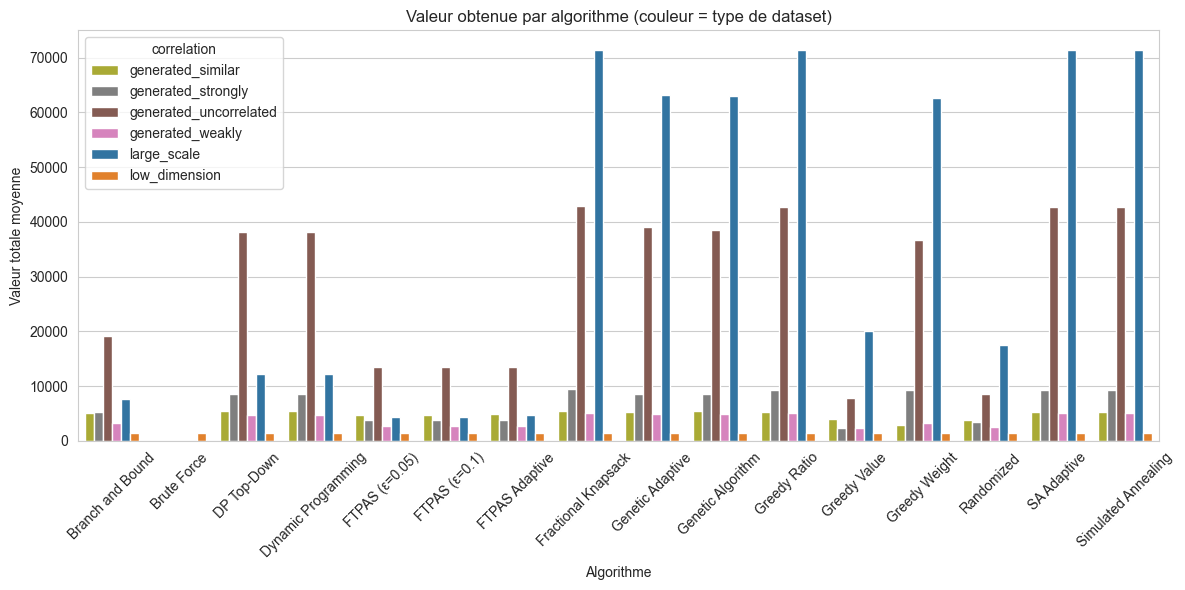

In [34]:
# Graphique 1 : Qualité (valeur totale) par algorithme, couleur = correlation
if results_df is not None:
    df = results_df.copy()
    # moyenne valeur par algorithme x correlation
    agg = df.groupby(['algorithm', 'correlation'])['value'].mean().reset_index()
    
    plt.figure(figsize=(12,6))
    # Palette pour toutes les catégories
    palette_map = {
        'large_scale': '#1f77b4',
        'low_dimension': '#ff7f0e',
        'uncorrelated': '#2ca02c',
        'weakly_correlated': '#d62728',
        'strongly_correlated': '#9467bd',
        'generated_uncorrelated': '#8c564b',
        'generated_weakly_correlated': '#e377c2',
        'generated_strongly_correlated': '#7f7f7f',
        'generated_similar_weights': '#bcbd22',
        'generated_inverse_strongly_correlated': '#17becf',
        # Versions courtes au cas où
        'generated_weakly': '#e377c2',
        'generated_strongly': '#7f7f7f',
        'generated_similar': '#bcbd22',
    }
    # Filtrer la palette pour ne garder que les catégories présentes
    categories_present = agg['correlation'].unique()
    palette_filtered = {k: v for k, v in palette_map.items() if k in categories_present}
    # Ajouter des couleurs auto pour catégories inconnues
    for cat in categories_present:
        if cat not in palette_filtered:
            palette_filtered[cat] = None
    
    sns.barplot(data=agg, x='algorithm', y='value', hue='correlation', palette=palette_filtered)
    plt.xlabel('Algorithme')
    plt.ylabel('Valeur totale moyenne')
    plt.title('Valeur obtenue par algorithme (couleur = type de dataset)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("results_df non chargé. Exécutez d'abord la cellule qui charge 'benchmark_results.csv'.")

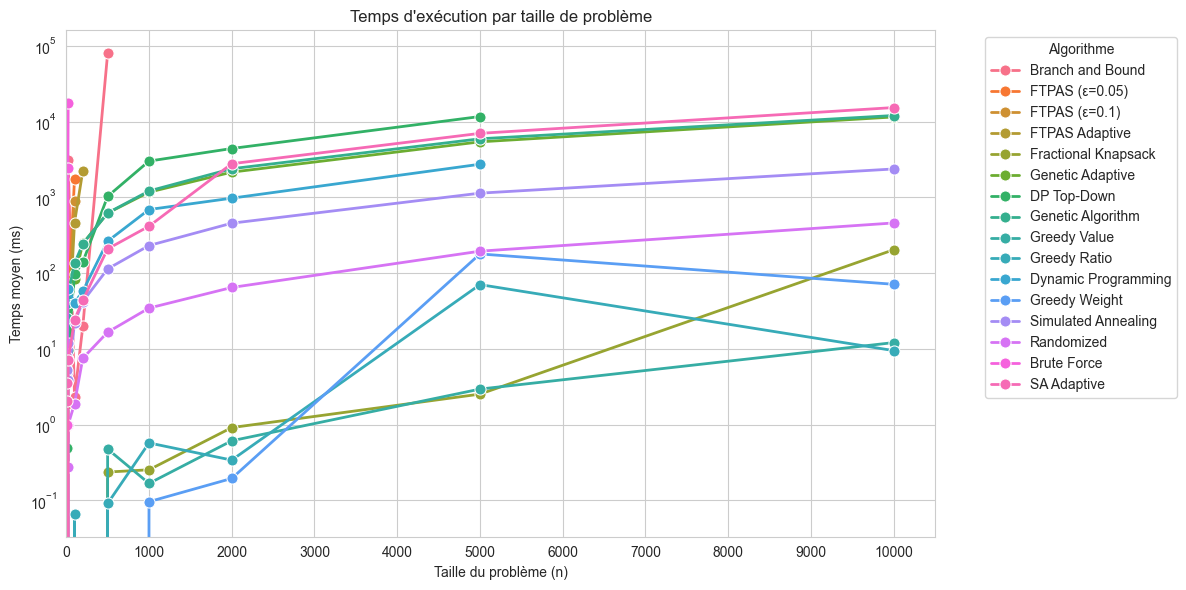

In [35]:
# Graphique 2 : Temps d'exécution par taille n
if results_df is not None:
    df = results_df.copy()
    
    # Moyenne du temps par algorithme et taille n
    agg_time = df.groupby(['algorithm', 'n'])['time_ms'].mean().reset_index()
    
    # Trier par n
    agg_time = agg_time.sort_values('n')
    
    plt.figure(figsize=(12,6))
    
    # Utiliser lineplot avec algorithme comme hue (couleur)
    sns.lineplot(data=agg_time, x='n', y='time_ms', hue='algorithm', marker='o', palette='husl', linewidth=2, markersize=8)
    
    plt.xlabel('Taille du problème (n)')
    plt.ylabel('Temps moyen (ms)')
    plt.title('Temps d\'exécution par taille de problème')
    plt.yscale('log')
    
    # Axe X avec ticks tous les 1000
    max_n = int(agg_time['n'].max())
    plt.xticks(range(0, max_n + 1000, 1000))
    plt.xlim(0, max_n + 500)
    
    plt.legend(title='Algorithme', bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print("results_df non chargé. Exécutez d'abord la cellule qui charge 'benchmark_results.csv'.")

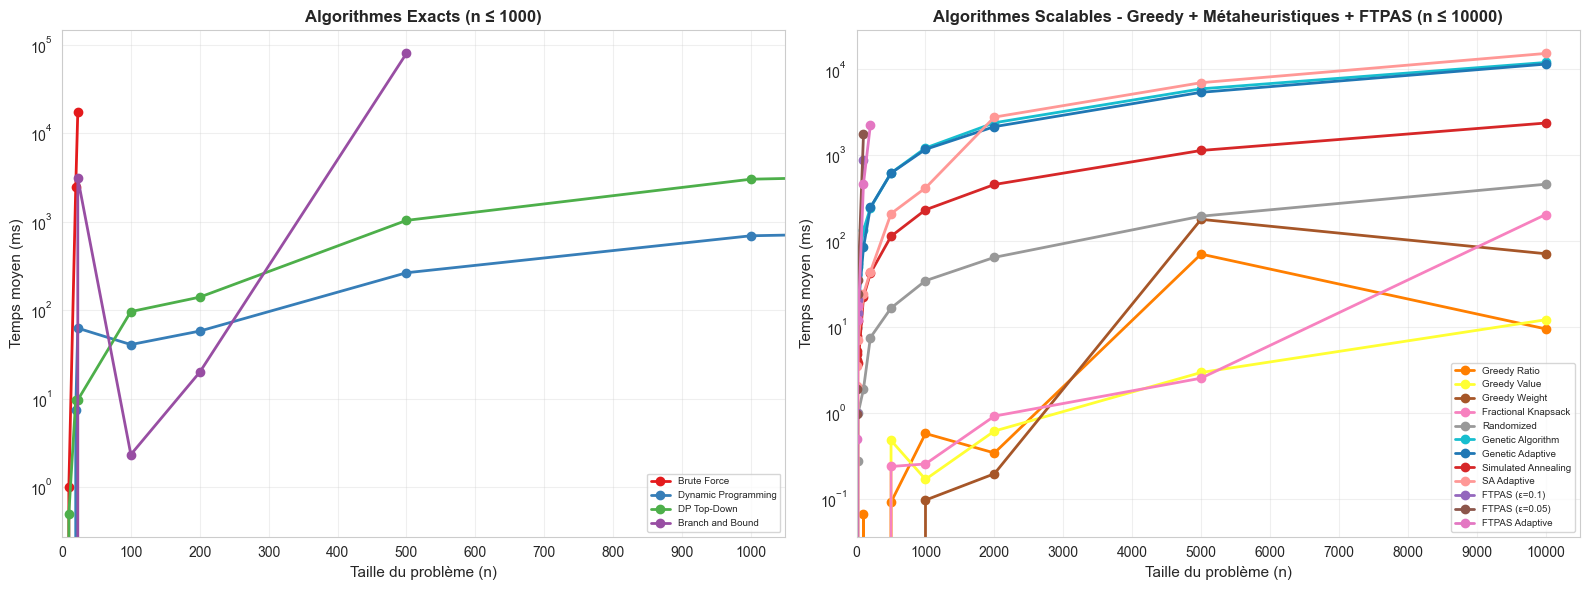

In [36]:
# Graphique 2bis : Temps d'exécution par groupe d'algorithmes
if results_df is not None:
    df = results_df.copy()
    agg_time = df.groupby(['algorithm', 'n'])['time_ms'].mean().reset_index()
    
    # Groupe 1: Algorithmes exacts (limités en taille)
    algos_limited = ['Brute Force', 'Dynamic Programming', 'DP Top-Down', 'Branch and Bound']
    
    # Groupe 2: Algorithmes scalables (Greedy + Métaheuristiques + FTPAS)
    algos_scalable = ['Greedy Ratio', 'Greedy Value', 'Greedy Weight', 'Fractional Knapsack',
                      'Randomized', 'Genetic Algorithm', 'Genetic Adaptive', 
                      'Simulated Annealing', 'SA Adaptive',
                      'FTPAS (ε=0.1)', 'FTPAS (ε=0.05)', 'FTPAS Adaptive']
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # --- Graphique 2a: Algorithmes Exacts + Métaheuristiques (n <= 1000) ---
    ax1 = axes[0]
    data_limited = agg_time[agg_time['algorithm'].isin(algos_limited)]
    for algo in algos_limited:
        algo_data = data_limited[data_limited['algorithm'] == algo].sort_values('n')
        if len(algo_data) > 0:
            color = ALGO_COLORS.get(algo, '#333333')
            ax1.plot(algo_data['n'], algo_data['time_ms'], 'o-', label=algo, color=color, linewidth=2, markersize=6)
    ax1.set_xlabel('Taille du problème (n)', fontsize=11)
    ax1.set_ylabel('Temps moyen (ms)', fontsize=11)
    ax1.set_title('Algorithmes Exacts (n ≤ 1000)', fontsize=12, fontweight='bold')
    ax1.set_yscale('log')
    ax1.set_xticks(range(0, 1100, 100))
    ax1.set_xlim(0, 1050)
    ax1.legend(fontsize=7, loc='lower right')
    ax1.grid(True, alpha=0.3)
    
    # --- Graphique 2b: Algorithmes Rapides (Greedy + FTPAS, n <= 10000) ---
    ax2 = axes[1]
    data_scalable = agg_time[agg_time['algorithm'].isin(algos_scalable)]
    for algo in algos_scalable:
        algo_data = data_scalable[data_scalable['algorithm'] == algo].sort_values('n')
        if len(algo_data) > 0:
            color = ALGO_COLORS.get(algo, '#333333')
            ax2.plot(algo_data['n'], algo_data['time_ms'], 'o-', label=algo, color=color, linewidth=2, markersize=6)
    ax2.set_xlabel('Taille du problème (n)', fontsize=11)
    ax2.set_ylabel('Temps moyen (ms)', fontsize=11)
    ax2.set_title('Algorithmes Scalables - Greedy + Métaheuristiques + FTPAS (n ≤ 10000)', fontsize=12, fontweight='bold')
    ax2.set_yscale('log')
    ax2.set_xticks(range(0, 11000, 1000))
    ax2.set_xlim(0, 10500)
    ax2.legend(fontsize=7, loc='lower right')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("results_df non chargé.")

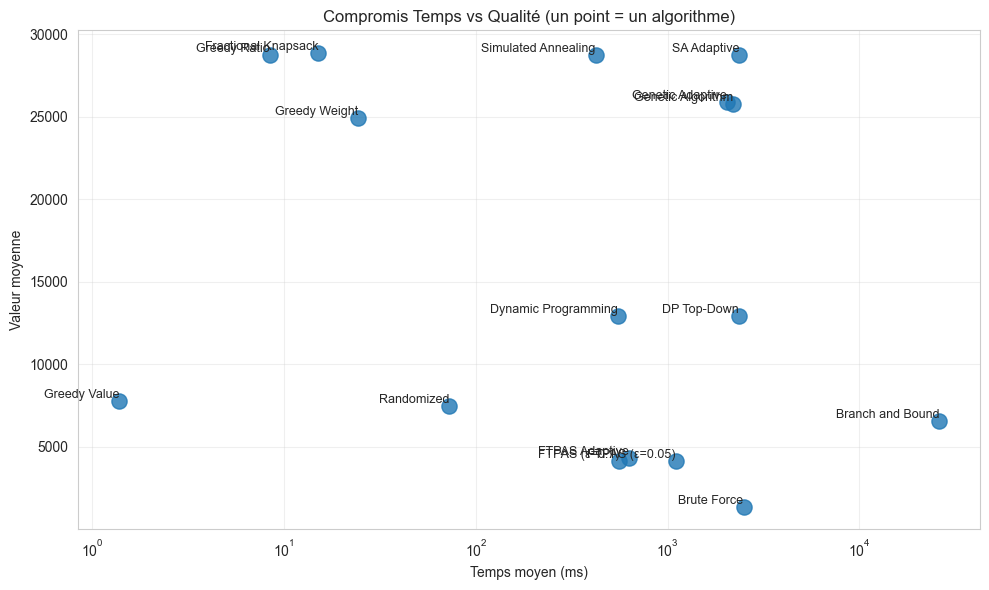

In [37]:
# Graphique 3 : Scatter Temps (X) vs Valeur (Y), 1 point = 1 algorithme (moyennes), annoté
if results_df is not None:
    df = results_df.copy()
    # prendre la moyenne temps et valeur par algorithme
    summary = df.groupby('algorithm').agg({'time_ms':'mean','value':'mean'}).reset_index()
    
    plt.figure(figsize=(10,6))
    plt.scatter(summary['time_ms'], summary['value'], s=120, alpha=0.8)
    for i, row in summary.iterrows():
        plt.text(row['time_ms'], row['value'], row['algorithm'], fontsize=9,
                 verticalalignment='bottom', horizontalalignment='right')
    plt.xscale('log')
    plt.xlabel('Temps moyen (ms)')
    plt.ylabel('Valeur moyenne')
    plt.title('Compromis Temps vs Qualité (un point = un algorithme)')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("results_df non chargé. Exécutez d'abord la cellule qui charge 'benchmark_results.csv'.")

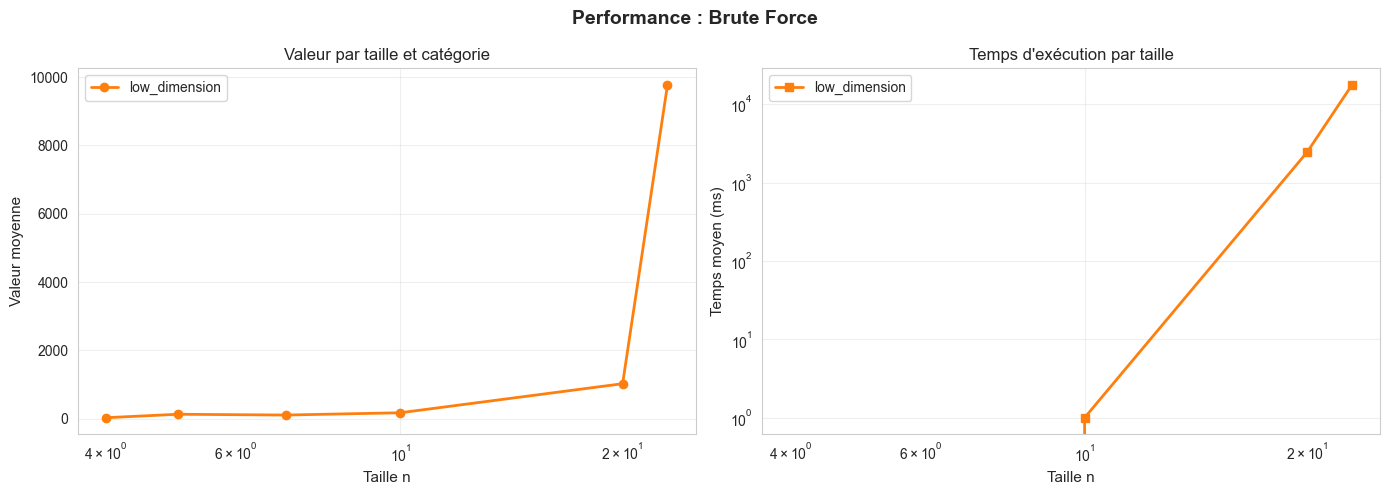

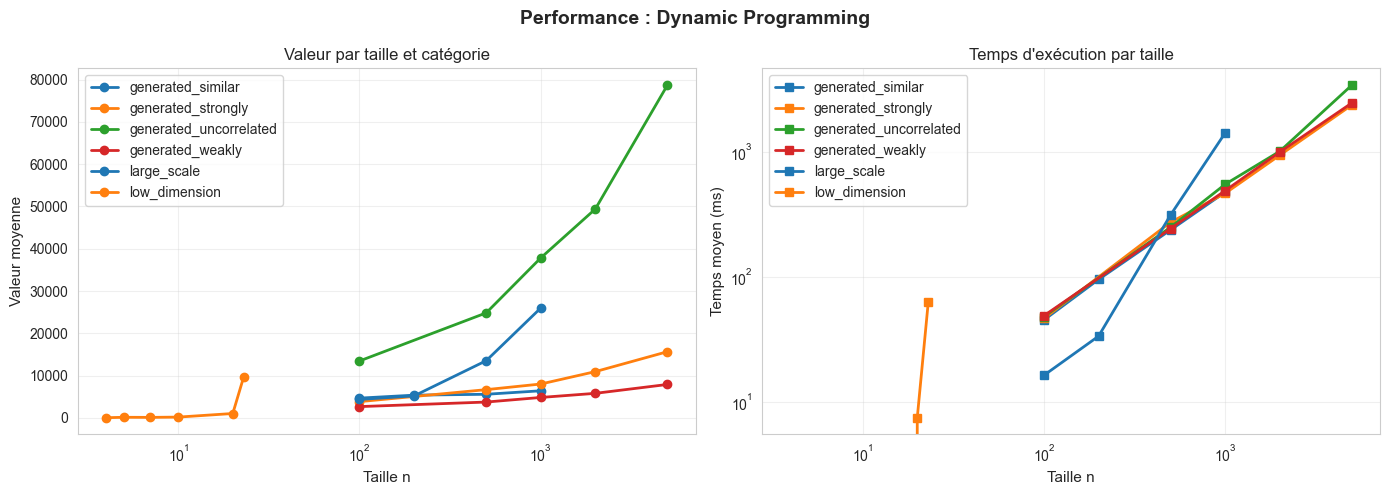

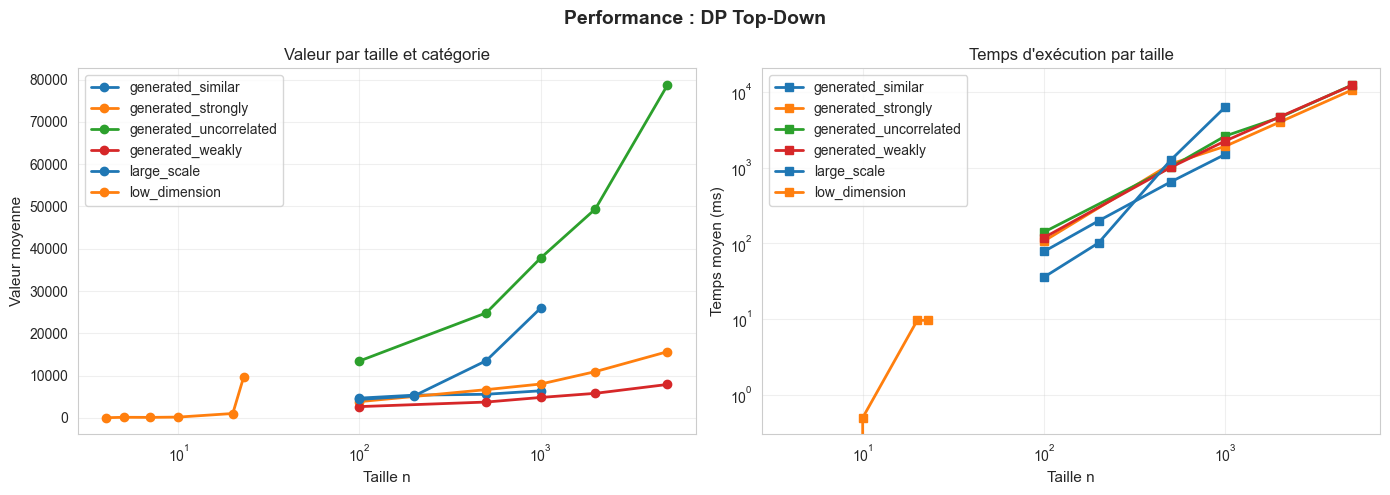

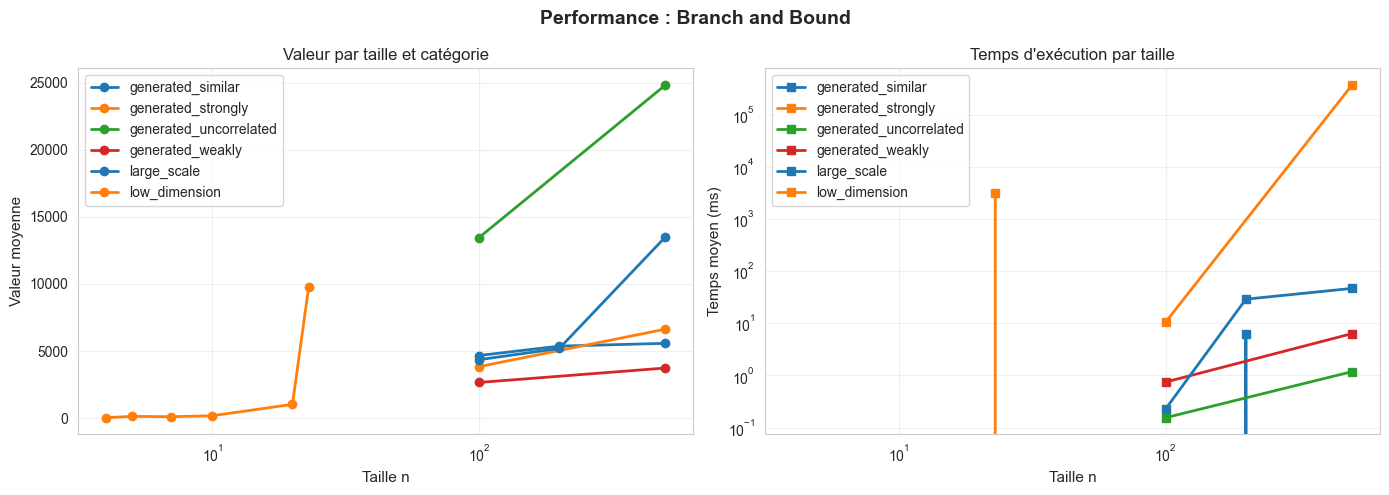

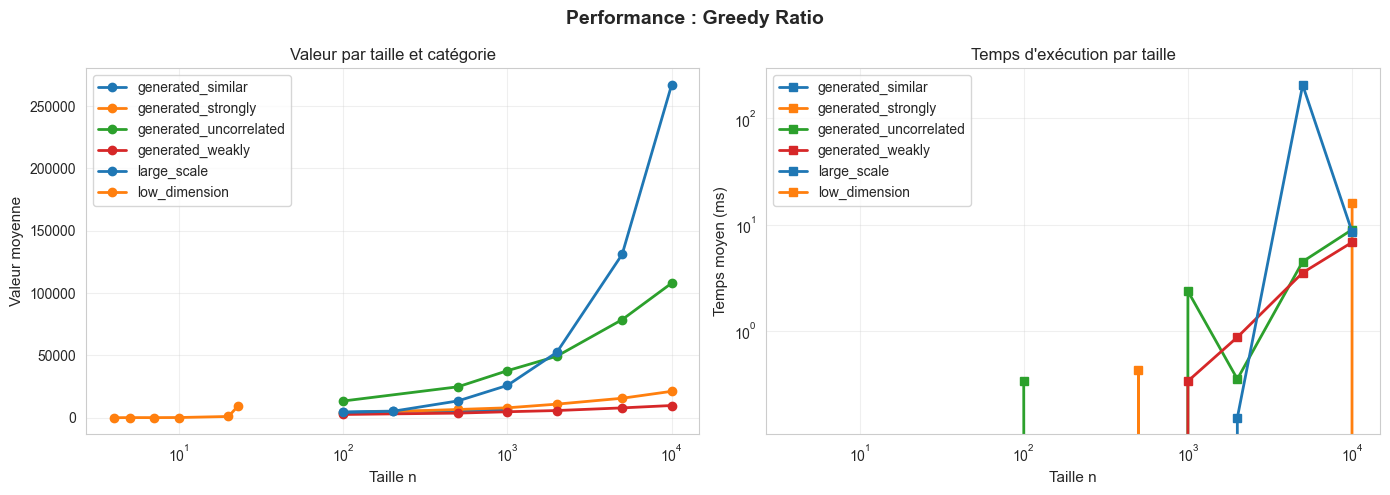

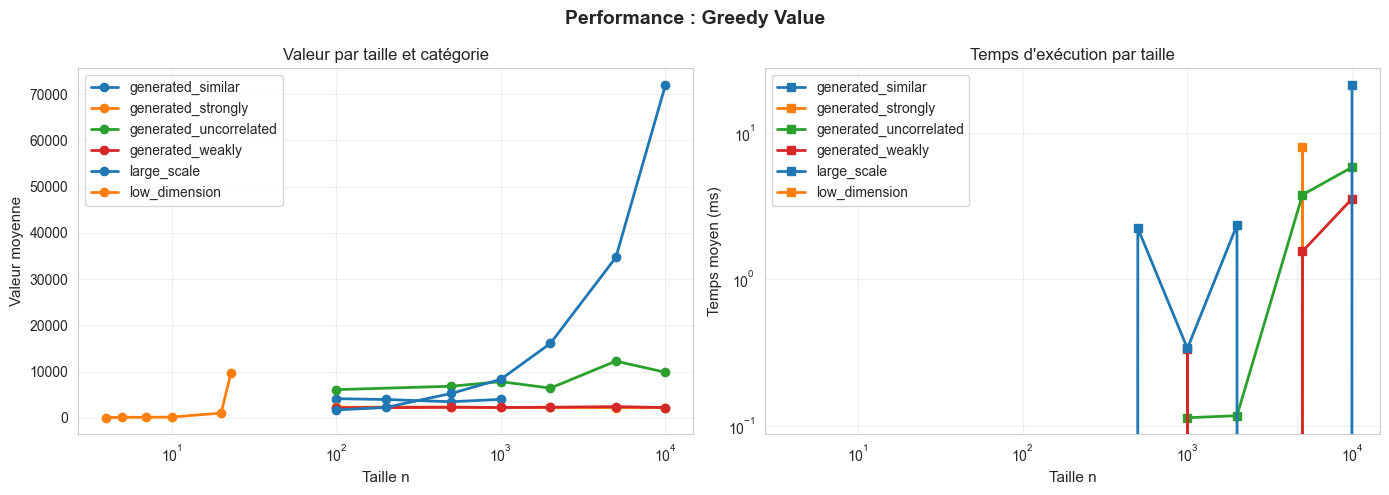

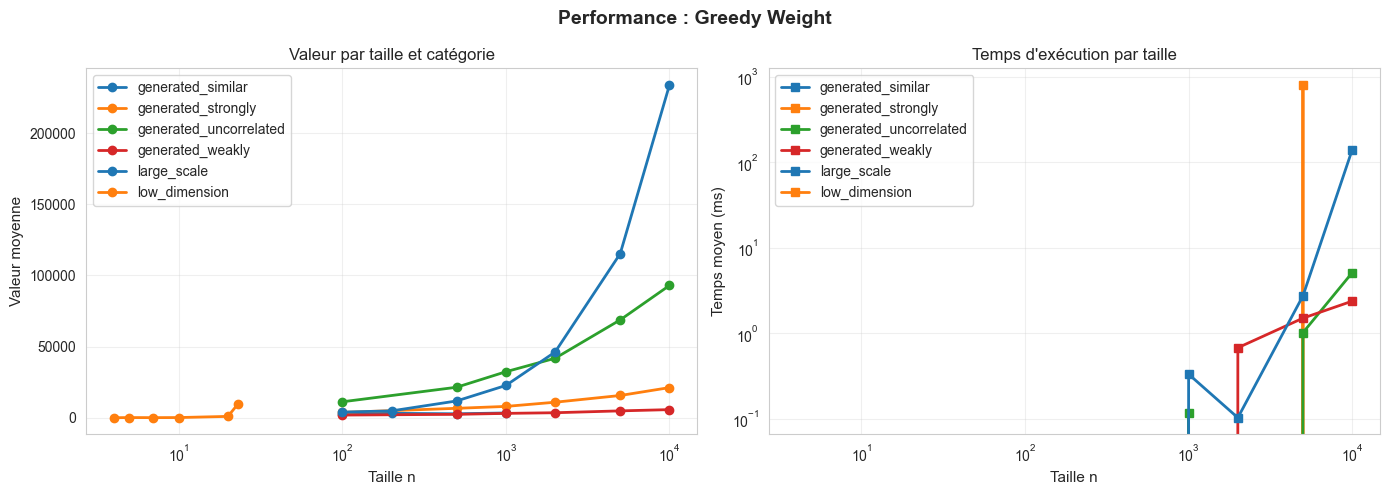

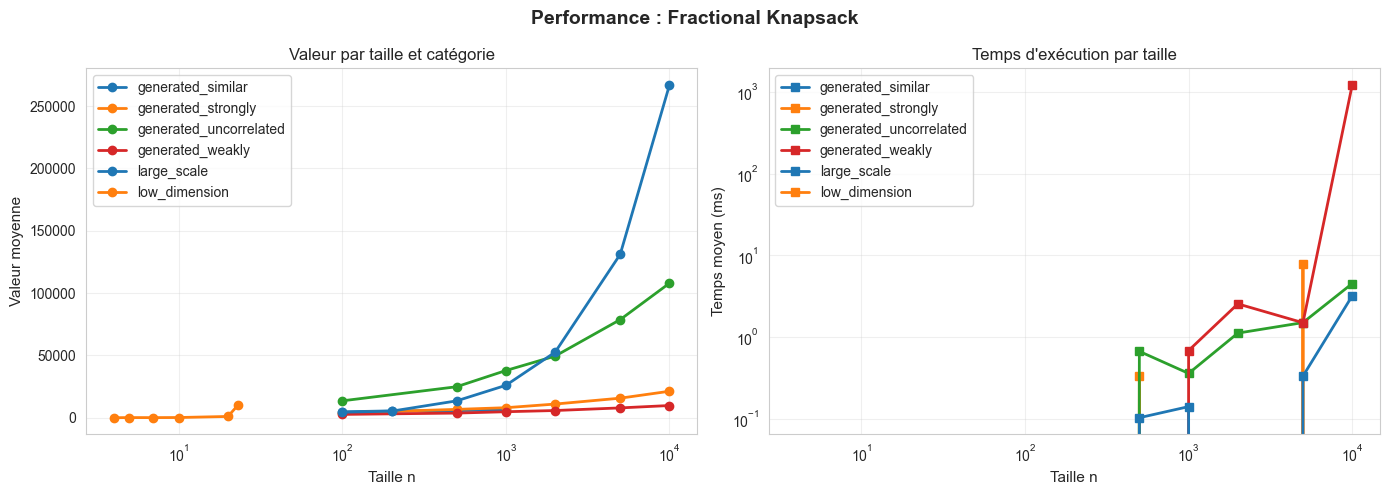

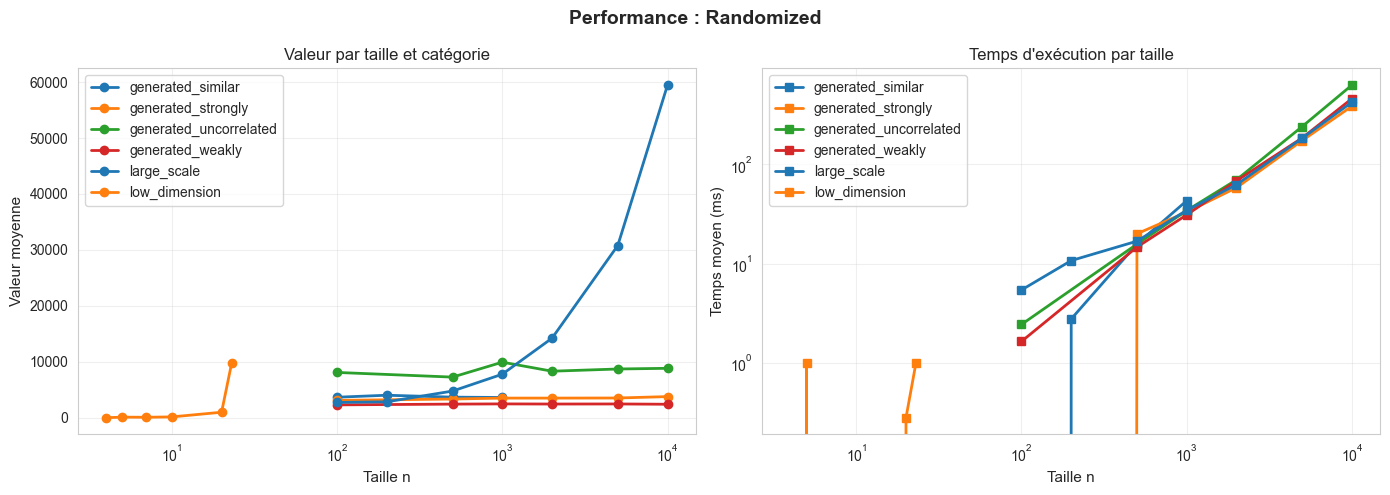

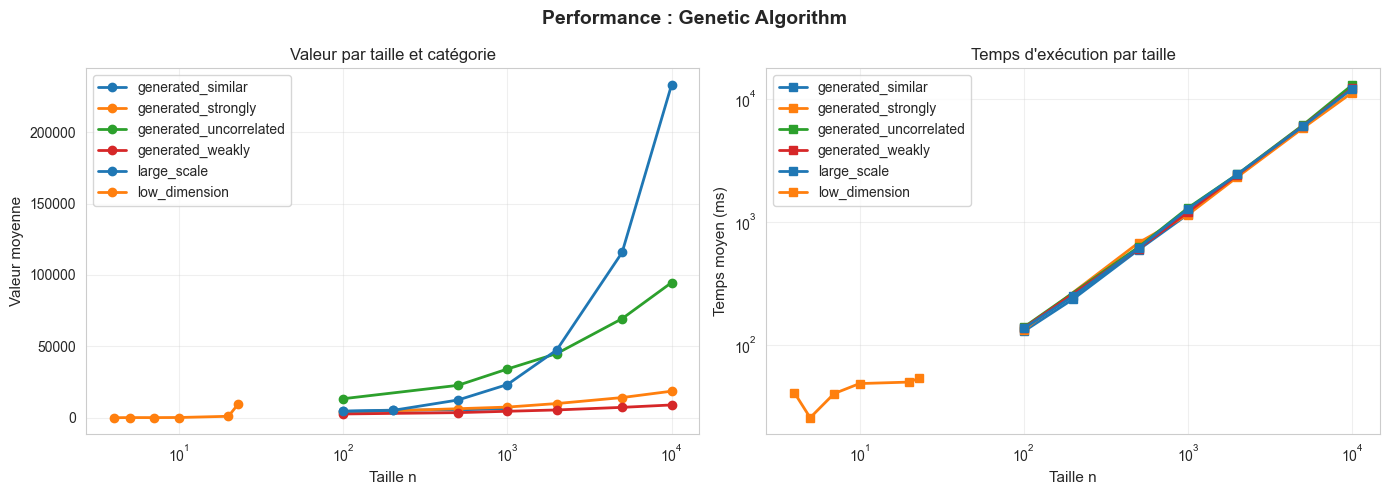

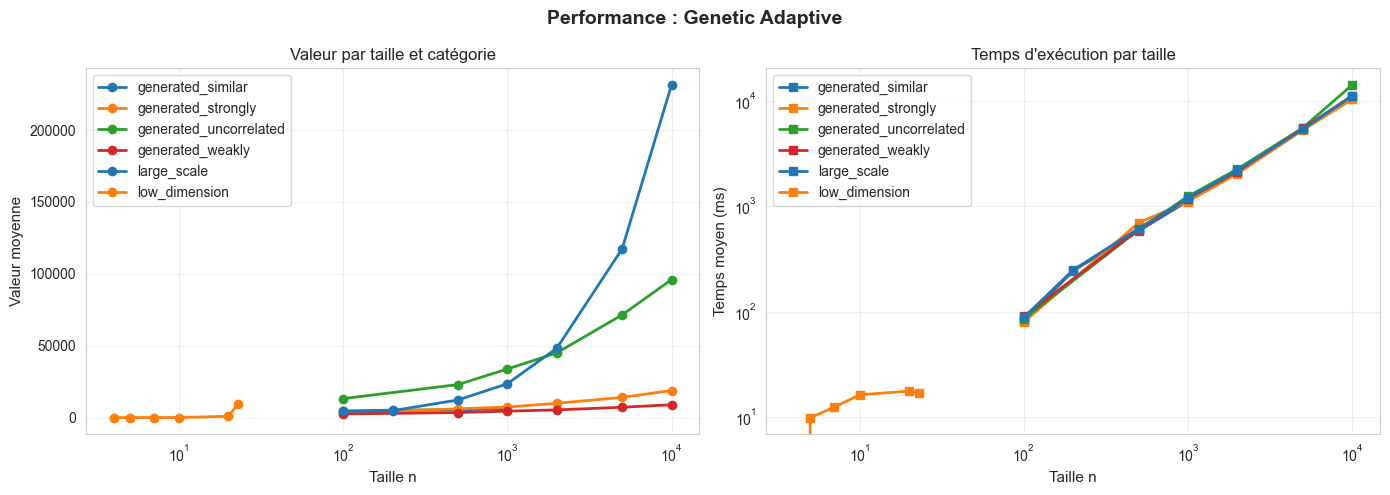

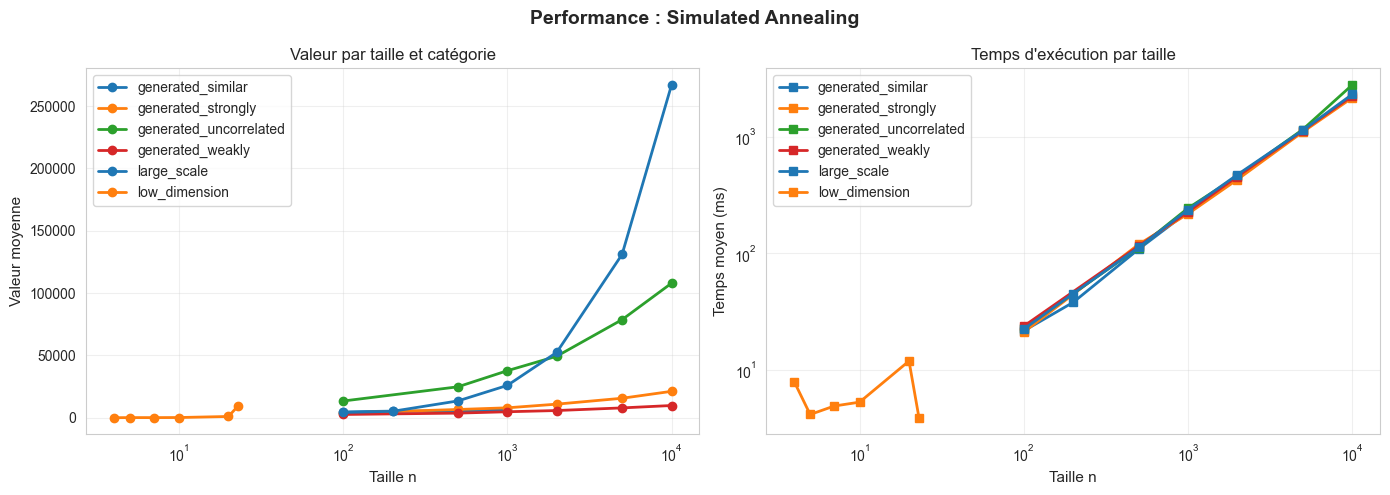

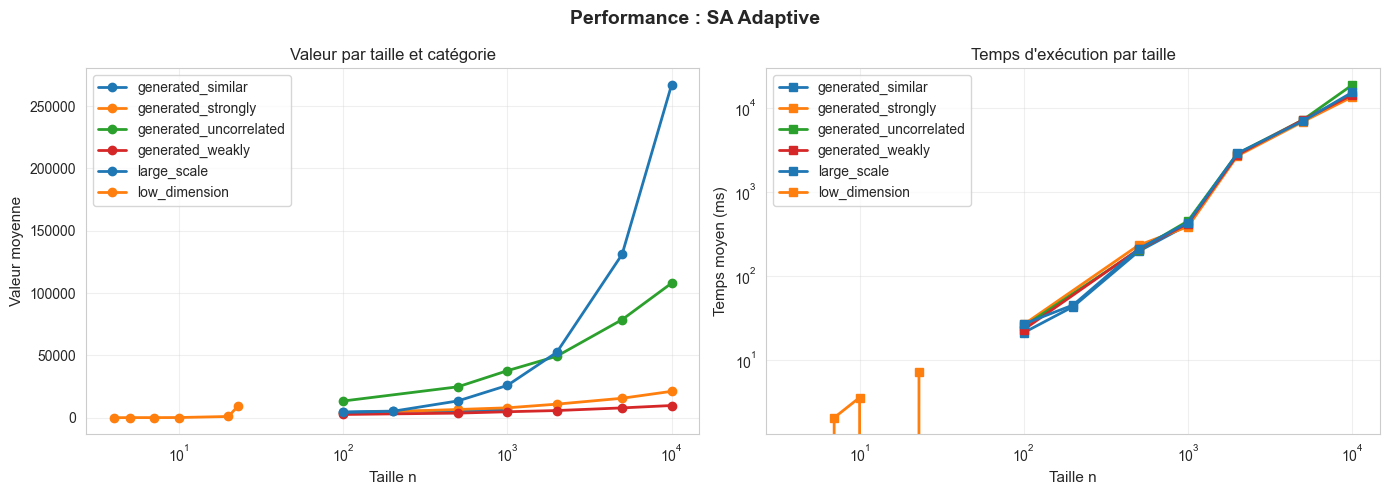

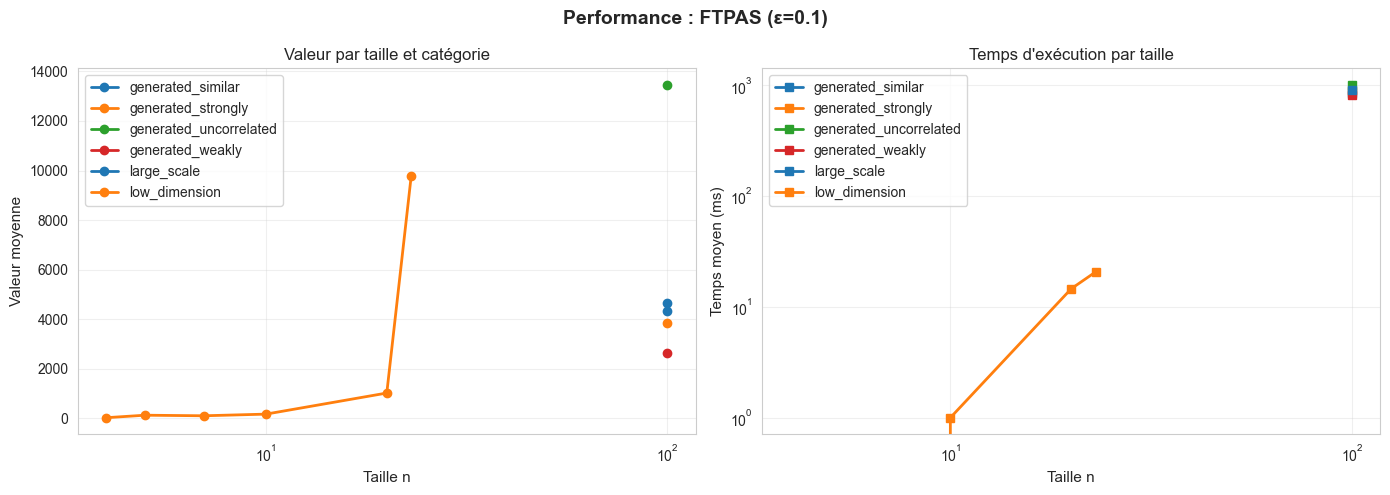

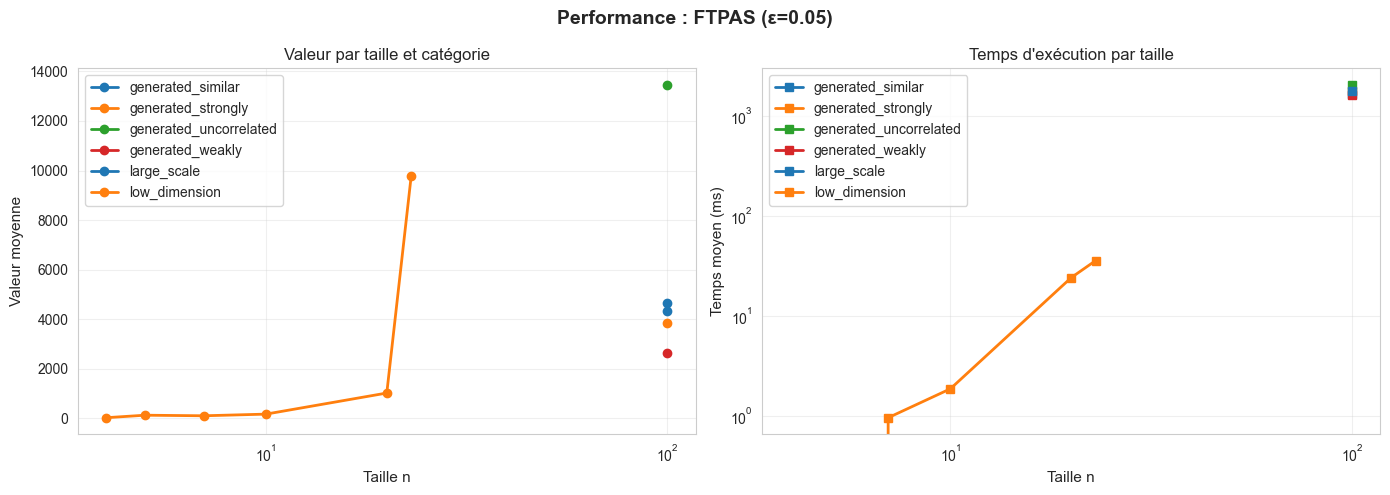

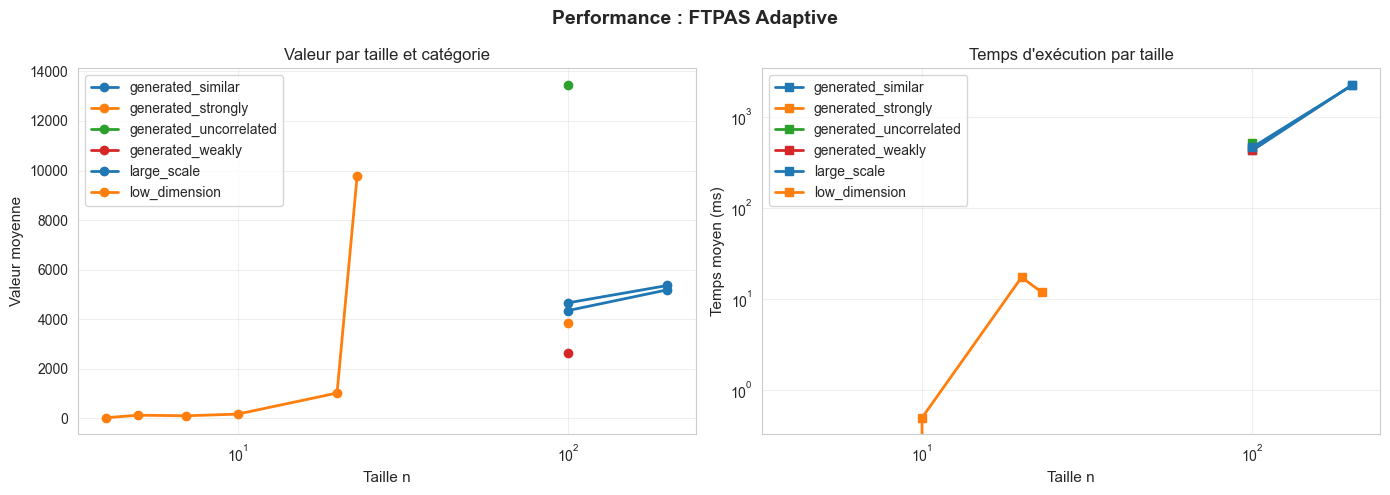

In [38]:
if results_df is not None:
    df = results_df.copy()
    
    algorithms = df['algorithm'].unique()
    
    # couleurs pour les deux catégories principales
    colors_cat = {'large_scale':'#1f77b4','low_dimension':'#ff7f0e'}
    
    for algo in algorithms:
        algo_data = df[df['algorithm'] == algo].copy()
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        fig.suptitle(f'Performance : {algo}', fontsize=14, fontweight='bold')
        
        # Valeur par catégorie et taille n
        if 'category' in algo_data.columns:
            agg_value = algo_data.groupby(['category', 'n'])['value'].mean().reset_index()
            groups = agg_value['category'].unique()
        else:
            # fallback vers 'correlation' si présent
            agg_value = algo_data.groupby(['correlation', 'n'])['value'].mean().reset_index()
            agg_value = agg_value.rename(columns={'correlation':'category'})
            groups = agg_value['category'].unique()

        for cat in groups:
            cat_data = agg_value[agg_value['category'] == cat]
            axes[0].plot(cat_data['n'], cat_data['value'], marker='o', label=cat, linewidth=2,
                         color=colors_cat.get(cat, None))
        
        axes[0].set_xlabel('Taille n', fontsize=11)
        axes[0].set_ylabel('Valeur moyenne', fontsize=11)
        axes[0].set_title('Valeur par taille et catégorie')
        axes[0].legend()
        axes[0].grid(alpha=0.3)
        axes[0].set_xscale('log')
        
        # Temps d'exécution par taille n
        if 'category' in algo_data.columns:
            agg_time = algo_data.groupby(['category', 'n'])['time_ms'].mean().reset_index()
        else:
            agg_time = algo_data.groupby(['correlation', 'n'])['time_ms'].mean().reset_index()
            agg_time = agg_time.rename(columns={'correlation':'category'})

        for cat in agg_time['category'].unique():
            cat_data = agg_time[agg_time['category'] == cat]
            axes[1].plot(cat_data['n'], cat_data['time_ms'], marker='s', label=cat, linewidth=2,
                         color=colors_cat.get(cat, None))
        
        axes[1].set_xlabel('Taille n', fontsize=11)
        axes[1].set_ylabel('Temps moyen (ms)', fontsize=11)
        axes[1].set_title('Temps d\'exécution par taille')
        axes[1].legend()
        axes[1].grid(alpha=0.3)
        axes[1].set_xscale('log')
        axes[1].set_yscale('log')
        
        plt.tight_layout()
        plt.show()
        print(f"\n{'='*60}\n")
else:
    print("results_df non chargé. Exécutez d'abord la cellule qui charge 'benchmark_results.csv'.")

### 6.2 Analyse par Type de Corrélation

Ces graphiques comparent les performances des algorithmes selon le type de données :
- **uncorrelated**: Poids et valeurs indépendants
- **weakly_correlated**: Légère corrélation entre poids et valeurs  
- **strongly_correlated**: Forte corrélation (valeur ≈ poids + constante)

Les instances fortement corrélées sont généralement plus difficiles pour les heuristiques.

In [39]:
# Graphique 4 : Comparaison par type de corrélation
if results_df is not None:
    df = results_df.copy()
    
    # Vérifier quels types de corrélation sont présents
    correlation_types = df['correlation'].unique()
    print(f"Types de corrélation présents: {correlation_types}")
    
    # Palette de couleurs pour les corrélations
    corr_colors = {
        'uncorrelated': '#2ecc71',        # Vert
        'weakly_correlated': '#f39c12',   # Orange
        'strongly_correlated': '#e74c3c', # Rouge
        'low_dimension': '#3498db',       # Bleu
        'large_scale': '#9b59b6'          # Violet
    }
    
    # Si on a les 3 types de corrélation, créer des graphiques comparatifs
    corr_types_present = [c for c in ['uncorrelated', 'weakly_correlated', 'strongly_correlated'] 
                          if c in correlation_types]
    
    if len(corr_types_present) > 0:
        print(f"\nAnalyse des corrélations: {corr_types_present}")
        
        # ---- Graphique 4a: Valeur moyenne par algorithme et corrélation ----
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Filtrer seulement les types de corrélation
        df_corr = df[df['correlation'].isin(corr_types_present)]
        
        if len(df_corr) > 0:
            # Valeur moyenne
            agg_val = df_corr.groupby(['algorithm', 'correlation'])['value'].mean().reset_index()
            pivot_val = agg_val.pivot(index='algorithm', columns='correlation', values='value')
            
            ax1 = axes[0]
            pivot_val.plot(kind='bar', ax=ax1, color=[corr_colors.get(c, '#333') for c in pivot_val.columns])
            ax1.set_xlabel('Algorithme', fontsize=11)
            ax1.set_ylabel('Valeur moyenne', fontsize=11)
            ax1.set_title('Valeur obtenue par type de corrélation', fontsize=12, fontweight='bold')
            ax1.tick_params(axis='x', rotation=45)
            ax1.legend(title='Corrélation')
            ax1.grid(alpha=0.3, axis='y')
            
            # Temps moyen
            agg_time = df_corr.groupby(['algorithm', 'correlation'])['time_ms'].mean().reset_index()
            pivot_time = agg_time.pivot(index='algorithm', columns='correlation', values='time_ms')
            
            ax2 = axes[1]
            pivot_time.plot(kind='bar', ax=ax2, color=[corr_colors.get(c, '#333') for c in pivot_time.columns])
            ax2.set_xlabel('Algorithme', fontsize=11)
            ax2.set_ylabel('Temps moyen (ms)', fontsize=11)
            ax2.set_title('Temps d\'exécution par type de corrélation', fontsize=12, fontweight='bold')
            ax2.tick_params(axis='x', rotation=45)
            ax2.set_yscale('log')
            ax2.legend(title='Corrélation')
            ax2.grid(alpha=0.3, axis='y')
            
            plt.tight_layout()
            plt.show()
        else:
            print("Pas de données pour les types de corrélation")
    else:
        print("\nLes benchmarks de corrélation (uncorrelated, weakly_correlated, strongly_correlated)")
        print("n'ont pas encore été exécutés.")
        print("Pour les inclure, relancez run_all_benchmarks() après avoir modifié discover_benchmarks()")
else:
    print("results_df non chargé.")

Types de corrélation présents: ['low_dimension' 'large_scale' 'generated_similar' 'generated_strongly'
 'generated_uncorrelated' 'generated_weakly']

Les benchmarks de corrélation (uncorrelated, weakly_correlated, strongly_correlated)
n'ont pas encore été exécutés.
Pour les inclure, relancez run_all_benchmarks() après avoir modifié discover_benchmarks()


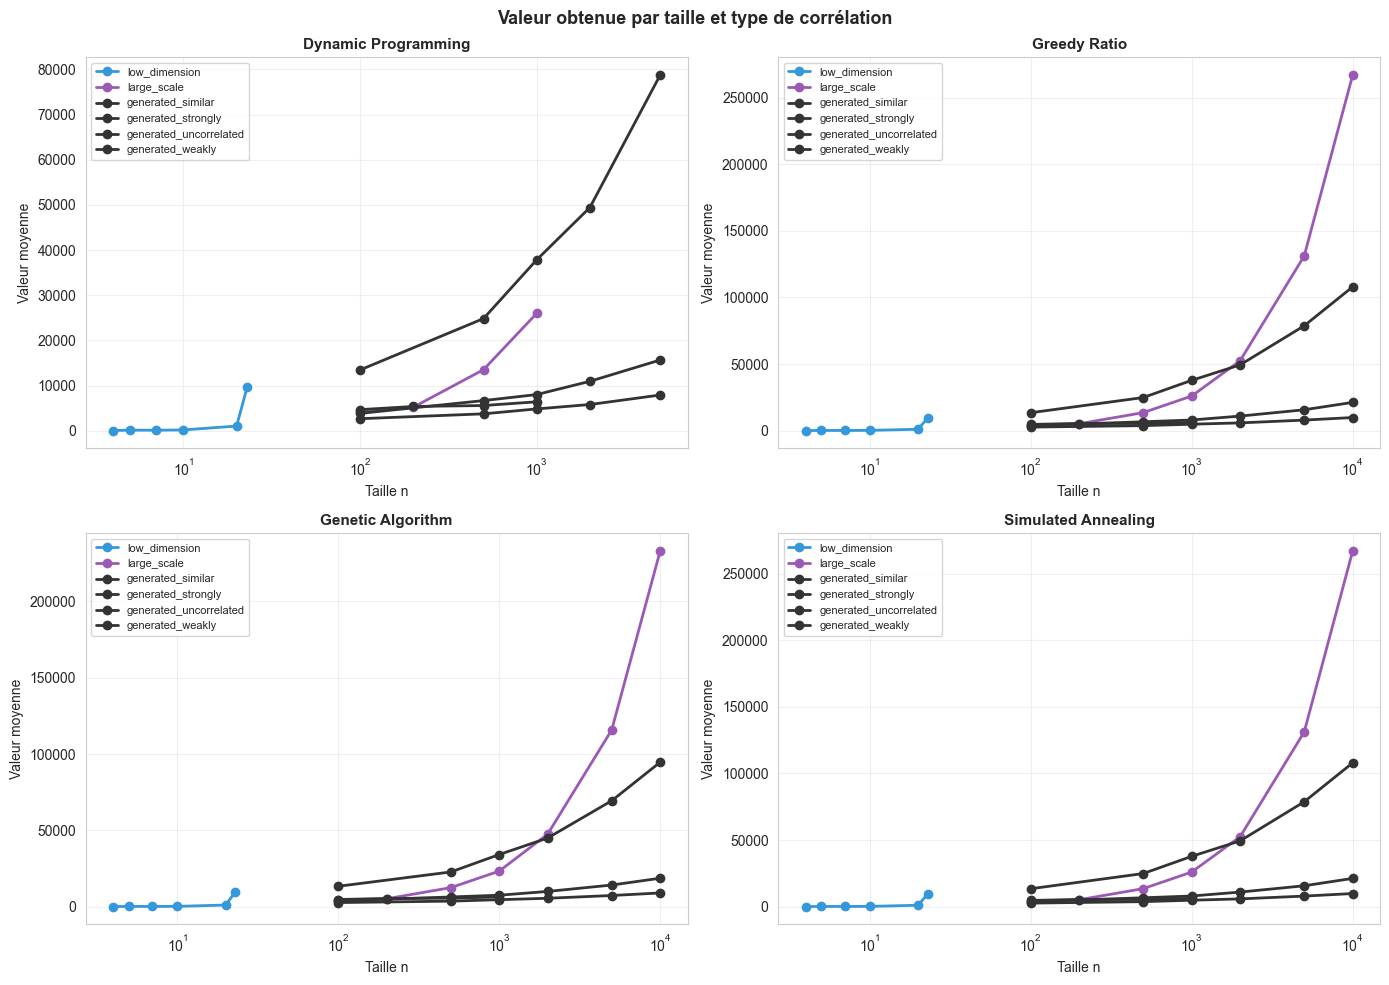

In [40]:
# Graphique 5 : Évolution des performances selon n pour chaque type de corrélation
if results_df is not None:
    df = results_df.copy()
    
    # Palette de couleurs pour les corrélations
    corr_colors = {
        'uncorrelated': '#2ecc71',
        'weakly_correlated': '#f39c12', 
        'strongly_correlated': '#e74c3c',
        'low_dimension': '#3498db',
        'large_scale': '#9b59b6'
    }
    
    # Sélectionner quelques algorithmes représentatifs pour la lisibilité
    algos_to_show = ['Dynamic Programming', 'Greedy Ratio', 'Genetic Algorithm', 'Simulated Annealing']
    algos_present = [a for a in algos_to_show if a in df['algorithm'].unique()]
    
    if len(algos_present) > 0:
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        axes = axes.flatten()
        
        for idx, algo in enumerate(algos_present[:4]):
            ax = axes[idx]
            algo_data = df[df['algorithm'] == algo]
            
            for corr in algo_data['correlation'].unique():
                corr_data = algo_data[algo_data['correlation'] == corr]
                agg = corr_data.groupby('n').agg({'value': 'mean', 'time_ms': 'mean'}).reset_index()
                agg = agg.sort_values('n')
                
                color = corr_colors.get(corr, '#333')
                ax.plot(agg['n'], agg['value'], 'o-', label=corr, color=color, linewidth=2, markersize=6)
            
            ax.set_xlabel('Taille n', fontsize=10)
            ax.set_ylabel('Valeur moyenne', fontsize=10)
            ax.set_title(f'{algo}', fontsize=11, fontweight='bold')
            ax.legend(fontsize=8)
            ax.grid(alpha=0.3)
            ax.set_xscale('log')
        
        plt.suptitle('Valeur obtenue par taille et type de corrélation', fontsize=13, fontweight='bold')
        plt.tight_layout()
        plt.show()
else:
    print("results_df non chargé.")

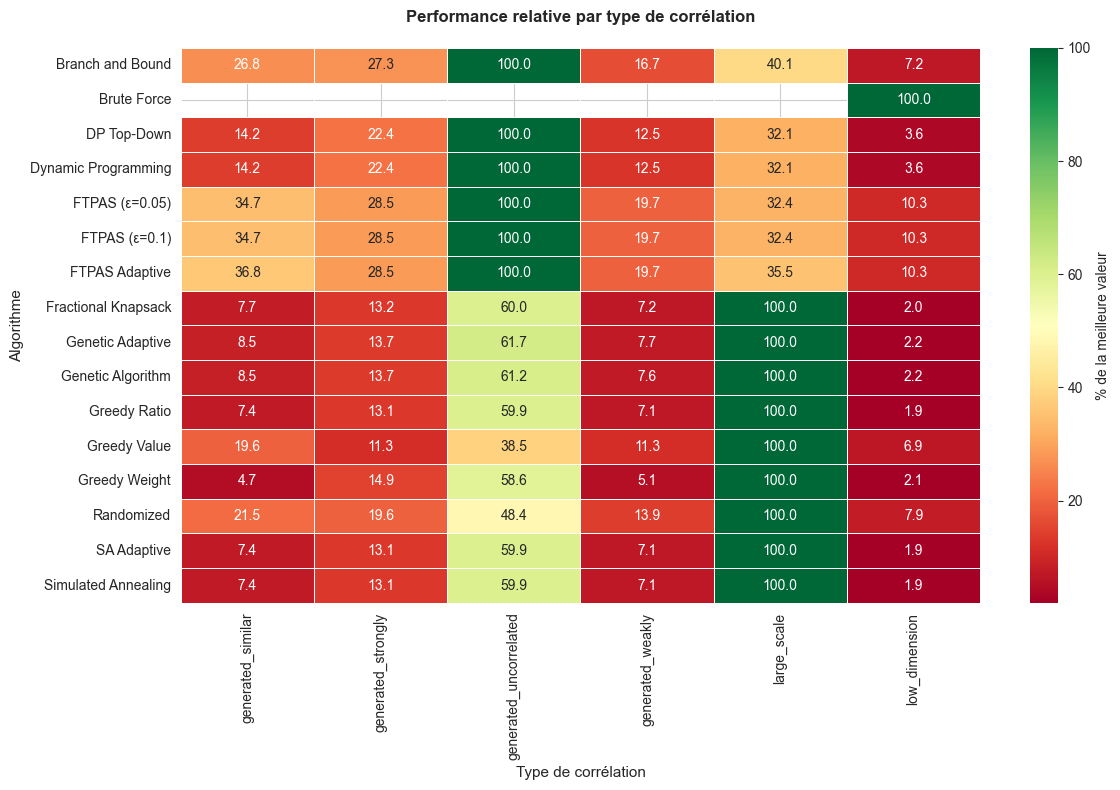

In [41]:
# Graphique 6 : Heatmap de performance relative par corrélation
if results_df is not None:
    df = results_df.copy()
    
    # Calculer la valeur moyenne par algorithme et corrélation
    pivot = df.groupby(['algorithm', 'correlation'])['value'].mean().unstack()
    
    if pivot.shape[1] > 1:  # Au moins 2 types de corrélation
        # Normaliser par ligne (algorithme) pour voir les différences relatives
        pivot_norm = pivot.div(pivot.max(axis=1), axis=0) * 100
        
        plt.figure(figsize=(12, 8))
        sns.heatmap(pivot_norm, annot=True, fmt='.1f', cmap='RdYlGn', 
                    cbar_kws={'label': '% de la meilleure valeur'},
                    linewidths=0.5)
        plt.title('Performance relative par type de corrélation\n', 
                  fontsize=12, fontweight='bold')
        plt.xlabel('Type de corrélation', fontsize=11)
        plt.ylabel('Algorithme', fontsize=11)
        plt.tight_layout()
        plt.show()
        
else:
    print("results_df non chargé.")

In [42]:
# Graphique 7 : Tableau récapitulatif détaillé
if results_df is not None:
    df = results_df.copy()
    
    # Créer un tableau récapitulatif complet
    summary = df.groupby(['correlation', 'algorithm']).agg({
        'value': ['mean', 'std', 'count'],
        'time_ms': ['mean', 'std'],
        'n': ['min', 'max']
    }).round(2)
    
    # Aplatir les colonnes multi-niveaux
    summary.columns = ['_'.join(col).strip() for col in summary.columns.values]
    summary = summary.reset_index()
    
    print("=" * 80)
    print("TABLEAU RÉCAPITULATIF DES RÉSULTATS PAR TYPE DE CORRÉLATION")
    print("=" * 80)
    
    for corr in summary['correlation'].unique():
        print(f"\n>>> {corr.upper()} <<<")
        print("-" * 60)
        corr_data = summary[summary['correlation'] == corr]
        
        # Trier par valeur moyenne décroissante
        corr_data = corr_data.sort_values('value_mean', ascending=False)
        
        for _, row in corr_data.iterrows():
            print(f"  {row['algorithm']:25s} | Valeur: {row['value_mean']:>10.1f} ± {row['value_std']:>8.1f} | "
                  f"Temps: {row['time_ms_mean']:>10.2f}ms | n: {int(row['n_min'])}-{int(row['n_max'])}")
    
    print("\n" + "=" * 80)
else:
    print("results_df non chargé.")

TABLEAU RÉCAPITULATIF DES RÉSULTATS PAR TYPE DE CORRÉLATION

>>> GENERATED_SIMILAR <<<
------------------------------------------------------------
  Fractional Knapsack       | Valeur:     5504.2 ±    769.4 | Temps:       0.00ms | n: 100-1000
  DP Top-Down               | Valeur:     5406.8 ±    792.5 | Temps:     546.44ms | n: 100-1000
  Dynamic Programming       | Valeur:     5406.8 ±    792.5 | Temps:     193.88ms | n: 100-1000
  Genetic Algorithm         | Valeur:     5374.2 ±    784.9 | Temps:     482.80ms | n: 100-1000
  Genetic Adaptive          | Valeur:     5340.2 ±    761.7 | Temps:     459.66ms | n: 100-1000
  Greedy Ratio              | Valeur:     5300.3 ±    729.3 | Temps:       0.00ms | n: 100-1000
  SA Adaptive               | Valeur:     5300.3 ±    729.3 | Temps:     149.30ms | n: 100-1000
  Simulated Annealing       | Valeur:     5300.3 ±    729.3 | Temps:      90.38ms | n: 100-1000
  Branch and Bound          | Valeur:     5123.4 ±    640.3 | Temps:       1.77ms | 

### 📌 Graphiques de Synthèse pour Présentation

Ces graphiques sont conçus pour résumer les résultats de manière visuelle et percutante.

C:\Users\jenki\AppData\Local\Temp\ipykernel_17748\1001228211.py:42: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\jenki\AppData\Local\Temp\ipykernel_17748\1001228211.py:42: UserWarning: Glyph 9889 (\N{HIGH VOLTAGE SIGN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\jenki\AppData\Local\Temp\ipykernel_17748\1001228211.py:42: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\jenki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jenki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9889 (\N{HIGH VOLTAGE SIGN}) missing from font(s)

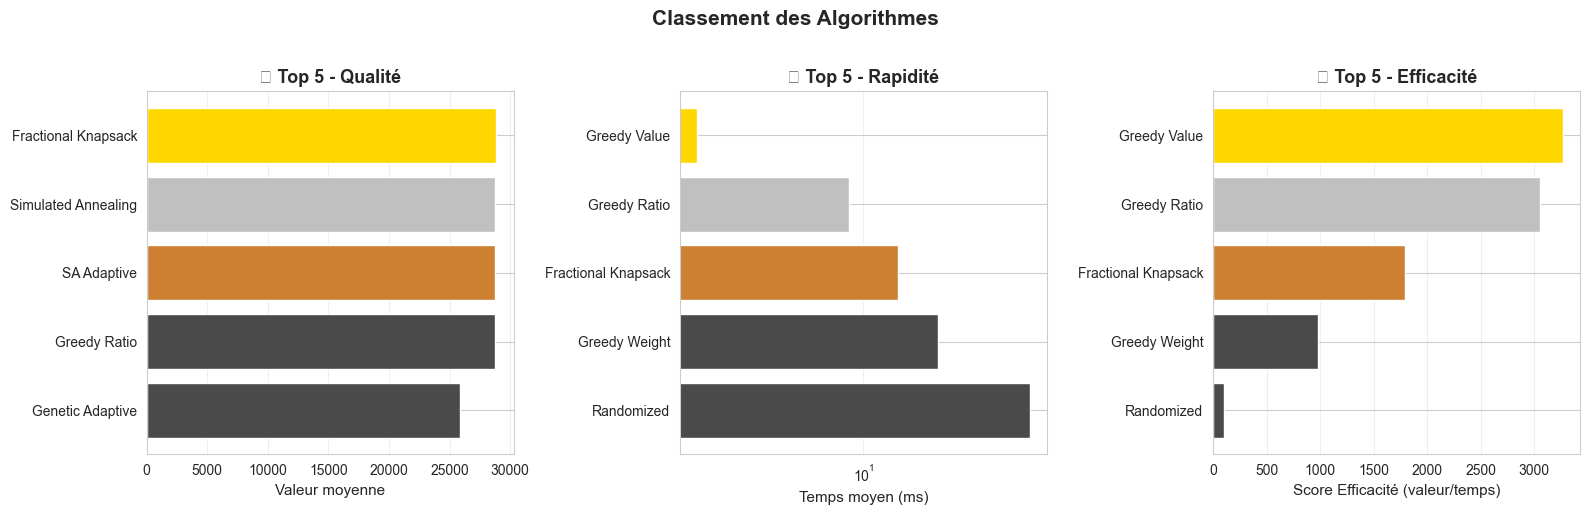

In [43]:
# ============================================================================
# GRAPHIQUE A : Podium des algorithmes (TOP 3 par catégorie)
# ============================================================================
# Résumé visuel des meilleurs algorithmes par critère

if results_df is not None:
    df = results_df.copy()
    
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    # --- 1. Top 3 par QUALITÉ (valeur moyenne) ---
    ax1 = axes[0]
    quality_rank = df.groupby('algorithm')['value'].mean().sort_values(ascending=False).head(5)
    colors_quality = ['#FFD700', '#C0C0C0', '#CD7F32', '#4a4a4a', '#4a4a4a']  # Or, Argent, Bronze
    bars1 = ax1.barh(quality_rank.index[::-1], quality_rank.values[::-1], color=colors_quality[::-1])
    ax1.set_xlabel('Valeur moyenne', fontsize=11)
    ax1.set_title('🏆 Top 5 - Qualité', fontsize=13, fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)
    
    # --- 2. Top 3 par RAPIDITÉ (temps moyen le plus bas) ---
    ax2 = axes[1]
    speed_rank = df.groupby('algorithm')['time_ms'].mean().sort_values(ascending=True).head(5)
    colors_speed = ['#FFD700', '#C0C0C0', '#CD7F32', '#4a4a4a', '#4a4a4a']
    bars2 = ax2.barh(speed_rank.index[::-1], speed_rank.values[::-1], color=colors_speed[::-1])
    ax2.set_xlabel('Temps moyen (ms)', fontsize=11)
    ax2.set_title('⚡ Top 5 - Rapidité', fontsize=13, fontweight='bold')
    ax2.set_xscale('log')
    ax2.grid(axis='x', alpha=0.3)
    
    # --- 3. Score combiné (qualité/temps) ---
    ax3 = axes[2]
    combined = df.groupby('algorithm').agg({'value': 'mean', 'time_ms': 'mean'})
    combined['efficiency'] = combined['value'] / (combined['time_ms'] + 1)  # +1 pour éviter div par 0
    efficiency_rank = combined['efficiency'].sort_values(ascending=False).head(5)
    colors_eff = ['#FFD700', '#C0C0C0', '#CD7F32', '#4a4a4a', '#4a4a4a']
    bars3 = ax3.barh(efficiency_rank.index[::-1], efficiency_rank.values[::-1], color=colors_eff[::-1])
    ax3.set_xlabel('Score Efficacité (valeur/temps)', fontsize=11)
    ax3.set_title('🎯 Top 5 - Efficacité', fontsize=13, fontweight='bold')
    ax3.grid(axis='x', alpha=0.3)
    
    plt.suptitle('Classement des Algorithmes', fontsize=15, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("results_df non chargé.")

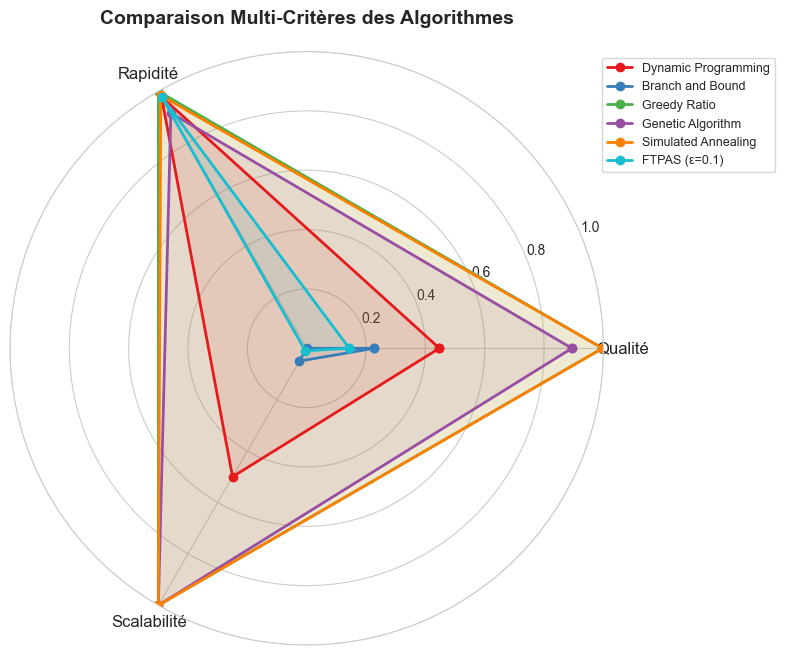

In [44]:
# ============================================================================
# GRAPHIQUE B : Radar Chart - Comparaison multi-critères
# ============================================================================
# Vue synthétique des forces/faiblesses de chaque algorithme

if results_df is not None:
    from math import pi
    
    df = results_df.copy()
    
    # Agréger les métriques par algorithme
    agg = df.groupby('algorithm').agg({
        'value': 'mean',
        'time_ms': 'mean',
        'n': 'max'  # Scalabilité max
    }).reset_index()
    
    # Normaliser les métriques entre 0 et 1
    agg['quality_norm'] = agg['value'] / agg['value'].max()
    agg['speed_norm'] = 1 - (agg['time_ms'] / agg['time_ms'].max())  # Inverser (plus rapide = mieux)
    agg['scalability_norm'] = agg['n'] / agg['n'].max()
    
    # Sélectionner 5-6 algorithmes représentatifs
    algos_radar = ['Dynamic Programming', 'Branch and Bound', 'Greedy Ratio', 
                   'Genetic Algorithm', 'Simulated Annealing', 'FTPAS (ε=0.1)']
    algos_present = [a for a in algos_radar if a in agg['algorithm'].values]
    
    if len(algos_present) >= 3:
        categories = ['Qualité', 'Rapidité', 'Scalabilité']
        N = len(categories)
        
        # Angles pour chaque axe
        angles = [n / float(N) * 2 * pi for n in range(N)]
        angles += angles[:1]  # Fermer le polygone
        
        fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
        
        colors_radar = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#17becf']
        
        for i, algo in enumerate(algos_present[:6]):
            algo_data = agg[agg['algorithm'] == algo].iloc[0]
            values = [algo_data['quality_norm'], algo_data['speed_norm'], algo_data['scalability_norm']]
            values += values[:1]  # Fermer
            
            ax.plot(angles, values, 'o-', linewidth=2, label=algo, color=colors_radar[i % len(colors_radar)])
            ax.fill(angles, values, alpha=0.1, color=colors_radar[i % len(colors_radar)])
        
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories, fontsize=12)
        ax.set_ylim(0, 1)
        ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=9)
        ax.set_title('Comparaison Multi-Critères des Algorithmes', fontsize=14, fontweight='bold', pad=20)
        
        plt.tight_layout()
        plt.show()
    else:
        print(f"Pas assez d'algorithmes pour le radar chart. Présents: {algos_present}")
else:
    print("results_df non chargé.")

C:\Users\jenki\AppData\Local\Temp\ipykernel_17748\337833306.py:72: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\jenki\AppData\Local\Temp\ipykernel_17748\337833306.py:72: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\jenki\AppData\Local\Temp\ipykernel_17748\337833306.py:72: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\jenki\AppData\Local\Temp\ipykernel_17748\337833306.py:72: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\jenki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jenki\AppData\Local\Packages\PythonSoftwareFoundati

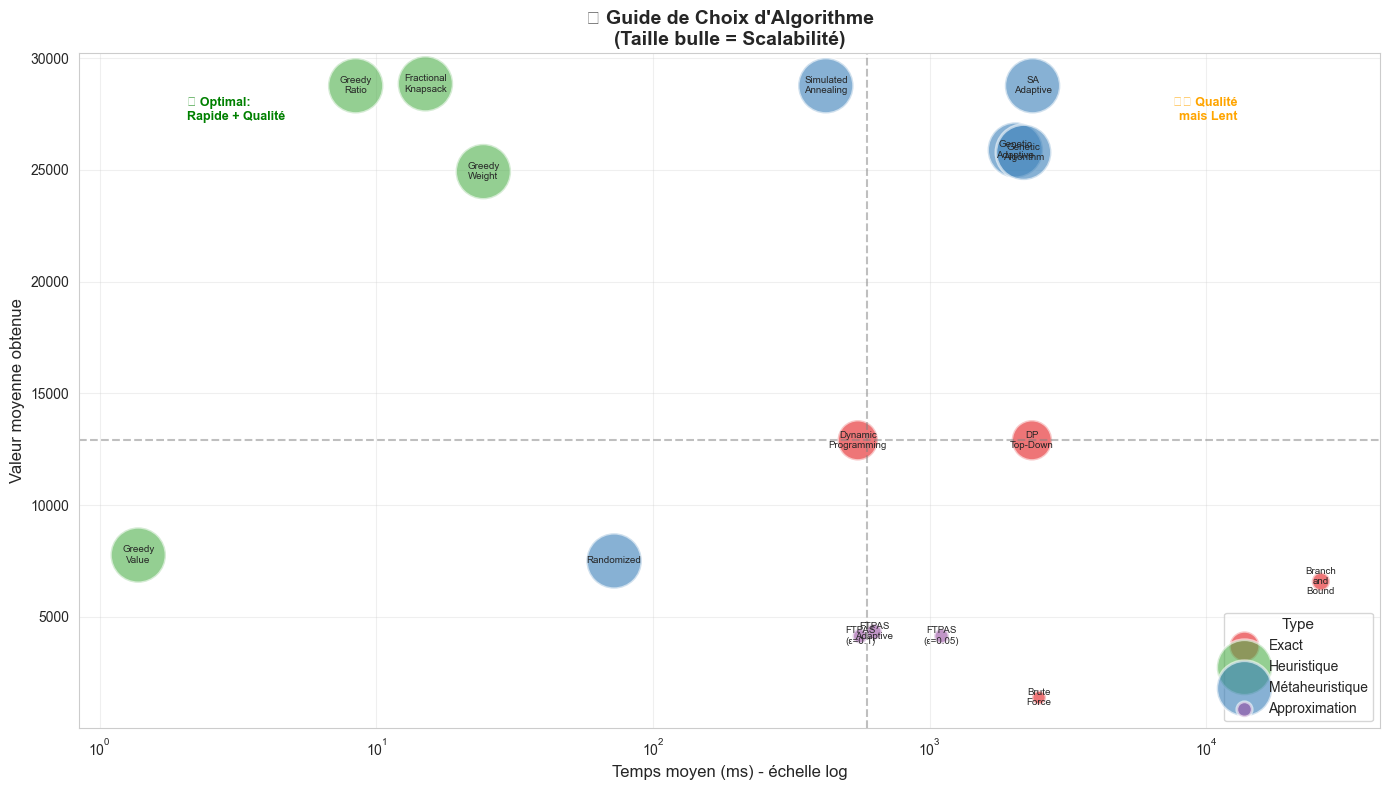

In [45]:
# ============================================================================
# GRAPHIQUE C : Diagramme de décision - Quel algorithme choisir ?
# ============================================================================
# Guide visuel pour le choix d'algorithme selon le contexte

if results_df is not None:
    df = results_df.copy()
    
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Calculer les statistiques par algorithme
    stats = df.groupby('algorithm').agg({
        'value': 'mean',
        'time_ms': 'mean',
        'n': 'max'
    }).reset_index()
    
    # Taille des bulles = scalabilité (n max)
    bubble_size = (stats['n'] / stats['n'].max()) * 1500 + 100
    
    # Couleur par type d'algorithme
    algo_types = {
        'Brute Force': 'Exact', 'Dynamic Programming': 'Exact', 'DP Top-Down': 'Exact',
        'Branch and Bound': 'Exact', 'Greedy Ratio': 'Heuristique', 'Greedy Value': 'Heuristique',
        'Greedy Weight': 'Heuristique', 'Fractional Knapsack': 'Heuristique',
        'Randomized': 'Métaheuristique', 'Genetic Algorithm': 'Métaheuristique',
        'Genetic Adaptive': 'Métaheuristique', 'Simulated Annealing': 'Métaheuristique',
        'SA Adaptive': 'Métaheuristique', 'FTPAS (ε=0.1)': 'Approximation',
        'FTPAS (ε=0.05)': 'Approximation', 'FTPAS Adaptive': 'Approximation'
    }
    
    type_colors = {'Exact': '#e41a1c', 'Heuristique': '#4daf4a', 
                   'Métaheuristique': '#377eb8', 'Approximation': '#984ea3'}
    
    stats['type'] = stats['algorithm'].map(algo_types)
    stats['color'] = stats['type'].map(type_colors)
    
    # Scatter plot
    for algo_type in type_colors:
        mask = stats['type'] == algo_type
        if mask.any():
            ax.scatter(stats.loc[mask, 'time_ms'], stats.loc[mask, 'value'],
                      s=bubble_size[mask], c=type_colors[algo_type], alpha=0.6,
                      label=algo_type, edgecolors='white', linewidth=2)
    
    # Annotations
    for _, row in stats.iterrows():
        ax.annotate(row['algorithm'].replace(' ', '\n'), 
                   (row['time_ms'], row['value']),
                   fontsize=7, ha='center', va='center')
    
    ax.set_xscale('log')
    ax.set_xlabel('Temps moyen (ms) - échelle log', fontsize=12)
    ax.set_ylabel('Valeur moyenne obtenue', fontsize=12)
    ax.set_title('🎯 Guide de Choix d\'Algorithme\n(Taille bulle = Scalabilité)', 
                fontsize=14, fontweight='bold')
    ax.legend(title='Type', fontsize=10, title_fontsize=11, loc='lower right')
    ax.grid(True, alpha=0.3)
    
    # Zones de recommandation
    ax.axhline(y=stats['value'].median(), color='gray', linestyle='--', alpha=0.5)
    ax.axvline(x=stats['time_ms'].median(), color='gray', linestyle='--', alpha=0.5)
    
    # Labels zones
    ymax, ymin = stats['value'].max(), stats['value'].min()
    xmax, xmin = stats['time_ms'].max(), stats['time_ms'].min()
    ax.text(xmin*1.5, ymax*0.98, '✅ Optimal:\nRapide + Qualité', fontsize=9, 
            color='green', fontweight='bold', va='top')
    ax.text(xmax*0.5, ymax*0.98, '⚠️ Qualité\nmais Lent', fontsize=9, 
            color='orange', fontweight='bold', va='top', ha='right')
    
    plt.tight_layout()
    plt.show()
else:
    print("results_df non chargé.")

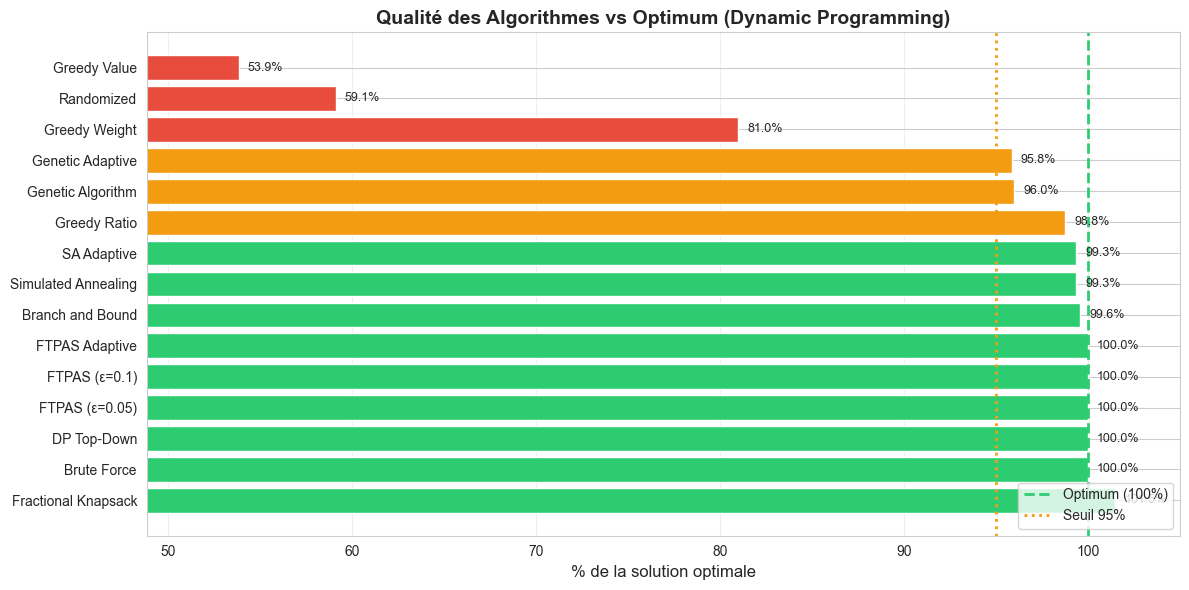

In [46]:
# ============================================================================
# GRAPHIQUE D : Gap à l'optimum (Qualité vs Solution exacte)
# ============================================================================
# Compare la qualité des heuristiques vs l'optimum (quand disponible)

if results_df is not None:
    df = results_df.copy()
    
    # Identifier la solution exacte de référence (DP ou B&B)
    exact_algos = ['Dynamic Programming', 'DP Top-Down', 'Branch and Bound']
    exact_algo = None
    for algo in exact_algos:
        if algo in df['algorithm'].unique():
            exact_algo = algo
            break
    
    if exact_algo:
        # Pivoter pour avoir l'optimum comme référence
        pivot = df.pivot_table(values='value', index=['correlation', 'n'], 
                               columns='algorithm', aggfunc='mean')
        
        if exact_algo in pivot.columns:
            # Calculer le gap (%) par rapport à l'optimum
            gap_df = (pivot.div(pivot[exact_algo], axis=0) * 100).reset_index()
            gap_melted = gap_df.melt(id_vars=['correlation', 'n'], 
                                      var_name='algorithm', value_name='gap_percent')
            
            # Exclure l'algo exact lui-même et filtrer les valeurs valides
            gap_melted = gap_melted[gap_melted['algorithm'] != exact_algo]
            gap_melted = gap_melted.dropna()
            
            if len(gap_melted) > 0:
                # Moyenne du gap par algorithme
                gap_summary = gap_melted.groupby('algorithm')['gap_percent'].mean().sort_values(ascending=False)
                
                fig, ax = plt.subplots(figsize=(12, 6))
                
                colors_gap = ['#2ecc71' if v >= 99 else '#f39c12' if v >= 95 else '#e74c3c' 
                             for v in gap_summary.values]
                
                bars = ax.barh(gap_summary.index, gap_summary.values, color=colors_gap, edgecolor='white')
                
                # Ligne de référence à 100%
                ax.axvline(x=100, color='#2ecc71', linestyle='--', linewidth=2, label='Optimum (100%)')
                ax.axvline(x=95, color='#f39c12', linestyle=':', linewidth=2, label='Seuil 95%')
                
                ax.set_xlabel('% de la solution optimale', fontsize=12)
                ax.set_title(f'Qualité des Algorithmes vs Optimum ({exact_algo})', 
                            fontsize=14, fontweight='bold')
                ax.set_xlim(min(gap_summary.min() - 5, 80), 105)
                ax.legend(loc='lower right')
                ax.grid(axis='x', alpha=0.3)
                
                # Annotations des valeurs
                for bar, val in zip(bars, gap_summary.values):
                    ax.text(val + 0.5, bar.get_y() + bar.get_height()/2, 
                           f'{val:.1f}%', va='center', fontsize=9)
                
                plt.tight_layout()
                plt.show()
            else:
                print("Pas assez de données pour calculer les gaps.")
        else:
            print(f"L'algorithme {exact_algo} n'est pas dans les colonnes pivotées.")
    else:
        print("Aucun algorithme exact trouvé pour référence.")
else:
    print("results_df non chargé.")

---
## 7. Analyse de Complexité

### 7.1 Complexité Théorique des Algorithmes

| Algorithme | Complexité Temporelle | Complexité Spatiale | Type |
|------------|----------------------|---------------------|------|
| **Brute Force** | $O(2^n)$ | $O(n)$ | Exact |
| **DP Bottom-Up** | $O(n \cdot C)$ | $O(n \cdot C)$ | Exact (pseudo-poly) |
| **DP Top-Down** | $O(n \cdot C)$ | $O(n \cdot C)$ | Exact (pseudo-poly) |
| **Branch & Bound** | $O(2^n)$ pire cas | $O(n)$ | Exact |
| **Greedy (ratio)** | $O(n \log n)$ | $O(n)$ | Approximation |
| **Fractional Knapsack** | $O(n \log n)$ | $O(n)$ | Exact (relaxé) |
| **Randomized** | $O(k \cdot n)$ | $O(n)$ | Heuristique |
| **Genetic Algorithm** | $O(g \cdot p \cdot n)$ | $O(p \cdot n)$ | Métaheuristique |
| **Simulated Annealing** | $O(i \cdot n)$ | $O(n)$ | Métaheuristique |
| **FPTAS** | $O(n^2 / \varepsilon)$ | $O(n / \varepsilon)$ | Approximation |

$n$ = nombre d'items
$C$ = capacité 
$k$ = itérations
$g$ = générations
$p$ = population
$i$ = itérations SA
$\varepsilon$ = paramètre d'approximation

### 7.2 Classification des Algorithmes

**Algorithmes Exacts:**
- Garantissent la solution optimale
- Brute Force: $O(2^n)$ - inutilisable pour $n > 25$
- DP: $O(n \cdot C)$ - pseudo-polynomial, dépend de la capacité
- Branch & Bound: Élagage efficace, souvent meilleur que $O(2^n)$ en pratique

**Algorithmes d'Approximation:**
- FPTAS garantit $(1-\varepsilon) \times OPT$ en temps polynomial
- Greedy ratio: approximation $\frac{1}{2} \times OPT$ garantie

**Métaheuristiques:**
- Pas de garantie théorique sur la qualité
- Genetic Algorithm et Simulated Annealing explorent l'espace de recherche
- Bons résultats en pratique, surtout pour grandes instances